## Importing model ensemble results ##

### Setup ###

In [17]:
# Import packages:
import sys, os
import importlib
import random
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import math
import itertools
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as plticker
import sklearn
from sklearn.preprocessing import MinMaxScaler
import karstnet as kn
import networkx as nx
from swmmtoolbox import swmmtoolbox as st

#Import local modules:
import mapping           #gempy mapping module add-on
import swmmpy as sp      #swmm wrapper
import sksin             #sks wrapper
import manager           #process manager

#matplotlib settings (embed plots, register datetime converters):
%matplotlib inline                 
register_matplotlib_converters()   


In [2]:
#Set paths and filenames:
#note: paths for subprocess module need to have forward slashes not backslashes (why?!)
#note: fixed paths are called '_path', filenames that may be modified and stored in various places are called '_file'

ID           =  'test'                                                        #start of model name string (will be added to during iteration)

#Paths:
input_path   =  r'C:\Users\Chloe\Documents\GitHub\gottesacker\input'        #path to data folder
output_path  =  r'C:\Users\Chloe\Documents\GitHub\gottesacker\output'
sks_path     = 'C:/Users/Chloe/Documents/GitHub/sks'                        #path to folder with SKS MATLAB scripts
sks_output   =  r'C:\Users\Chloe\Documents\GitHub\sks\output_SKS'           #path to SKS output folder 

#GemPy files:
dem_path           = os.path.join(input_path, 'DEMraster50_251x200.tif')    #DEM to be used to set model grid (should be rectangular)
points_path        = os.path.join(input_path, 'GK_all_points.csv')            #file with all geologic data points (must have columns: ID, X, Y, Z, formation, azimuth, dip, polarity, interface, overturned, erosion, source, type, use, order)
mask_path          = os.path.join(input_path, 'DEMraster50_basinmask_179x139.tif')           #raster cropped to catchment (see code in manual_testing.ipynb)

#SKS files:
spring_path        = os.path.join(sks_path, 'input', 'springs_correctedXYZ.txt')    #path to spring coordinate file (should be same for all models)
nodes_file         = 'SKS_nodes.dat'                                            #name to save SKS node coord file to (compatible w/ karstnet)
links_file         = 'SKS_links.dat'                                            #name to save SKS links file to (compatible w/ karstnet)
base_nodes_file    = os.path.join(input_path,  'base_nodes.dat')                #path to Zhao's nodes file
base_links_file    = os.path.join(input_path,  'base_links.dat')                #path to Zhao's links file

#SWMM files:
swmm_template_file  = os.path.join(input_path, 'swmm_template_auto.inp')    #filename for template .inp file to import
swmm_inputfile      = ID + '.inp'                                           #filename to write new .inp file to
swmm_reportfile     = ID + '.rpt'                                           #filename to write .rpt file to
swmm_outputfile     = ID + '.out'                                           #filename to write .out file to
rainfall_path       = os.path.join(input_path, 'rainfall.txt')              #fast-flow recharge input timeseries distributed in a 100mx100m cell grid
baseflow_path       = os.path.join(input_path, 'baseflow.txt')              #slow-flow recharge input timeseries distributed in a 100mx100m cell grid
grid_path           = os.path.join(input_path, 'grid100.csv')               #recharge input 100mx100m cell grid
Qobs_path           = os.path.join(input_path, 'Qobs.csv')                  #observed spring discharge timeseries at QS,QE,QA  
swmm_base_path      = os.path.join(input_path, 'base.inp')                  #reference model input file (with rainfall in mm and baseflow in mm)
swmm_base_outputfile = os.path.join(input_path, 'base.out')                 #reference model output file

In [3]:
#Define functions:
def plotQ(Q, c='k', lw=1, ls='-', label=False):
    '''Plot discharge from all three springs
       Note: An object named ax containing the three axes to plot on must exist.
       Q: pandas dataframe with a datetime index and the columns QE,QA,QS containing discharge timeseries.
       c: string indicating the line style and color to plot with (ex: '--k')
       lw,ls: line width and line style (optional)
       label: True/False - label y axes with spring names or not'''
       
    ax[0].plot(Q.QE, color=c, linewidth=lw, linestyle=ls)
    ax[1].plot(Q.QA, color=c, linewidth=lw, linestyle=ls)
    ax[2].plot(Q.QS, color=c, linewidth=lw, linestyle=ls)

    if label==True:
        ax[0].set_ylabel('QE')
        ax[1].set_ylabel('QA')
        ax[2].set_ylabel('QS')
        
def calcErrors(Q, Qobs, name, stats, threshold=[0.5,1,0.25]):
    '''Calculates RMSE, NSC, and VE, using swmmpy built-in functions, for all three springs (QE,QA,QS).
    Stores results in a multi-indexed dataframe. Dataframe must already exist - create it like this:
    index = pd.MultiIndex.from_product([['QE','QA','QS','Sum'], ['RMSE', 'NSC','VE']])
    stats = pd.DataFrame(columns=['obs'], index=index)

    Q: dataframe of simulated timeseries (returned by swmmpy.getQ()) with one column per spring
    Qobs: dataframe of observed timeseries with one column per spring
    name: text string indicating name of model
    stats: multi-index dataframe to store results in
    threshold: discharge value [in m3/sec] below which to consider flows as "low flow"'''
    
    stats.loc[('QE','NSC'),   name] = sp.NSC(  Qobs.QE, Q.QE)
    stats.loc[('QE','RMSE'),  name] = sp.RMSE( Qobs.QE, Q.QE)
    stats.loc[('QE','VE'),    name] = sp.VE(   Qobs.QE, Q.QE)
    stats.loc[('QE','meanQ'), name] = np.nanmean(Q.QE)
    stats.loc[('QE','minQ'),  name] = np.nanmin( Q.QE)
    stats.loc[('QE','maxQ'),  name] = np.nanmax( Q.QE)
    stats.loc[('QE','%lowQ'), name] = 100*(len(Q.QE[Q.QE<threshold[0]])/len(Q.QE))
    
    stats.loc[('QA','NSC'),   name] = sp.NSC(  Qobs.QA, Q.QA)
    stats.loc[('QA','RMSE'),  name] = sp.RMSE( Qobs.QA, Q.QA)
    stats.loc[('QA','VE'),    name] = sp.VE(   Qobs.QA, Q.QA)
    stats.loc[('QA','meanQ'), name] = np.nanmean(Q.QA)
    stats.loc[('QA','minQ'),  name] = np.nanmin( Q.QA)
    stats.loc[('QA','maxQ'),  name] = np.nanmax( Q.QA)
    stats.loc[('QA','%lowQ'), name] = 100*(len(Q.QA[Q.QA<threshold[1]])/len(Q.QA))
    
    stats.loc[('QS','NSC'),   name] = sp.NSC(  Qobs.QS, Q.QS)
    stats.loc[('QS','RMSE'),  name] = sp.RMSE( Qobs.QS, Q.QS)
    stats.loc[('QS','VE'),    name] = sp.VE(   Qobs.QS, Q.QS)
    stats.loc[('QS','meanQ'), name] = np.nanmean(Q.QS)
    stats.loc[('QS','minQ'),  name] = np.nanmin( Q.QS)
    stats.loc[('QS','maxQ'),  name] = np.nanmax( Q.QS)
    stats.loc[('QS','%lowQ'), name] = 100*(len(Q.QS[Q.QS<threshold[2]])/len(Q.QS))
    
    stats.sort_index(inplace=True)
    return stats

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=1000):
    '''Truncates an existing colormap to the desired interval and generates a new colormap with n colors.
    cmap:   existing matplotlib colormap
    minval: start value to slice from (min possible is 0)
    maxval: end value to slice to (max possible is 1)
    n:      number of color intervals to create in new colormap'''
    
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

### Import data ###

In [4]:
#Import ensemble modeling output info:
data             = pd.read_csv(os.path.join(output_path, ID+'data.csv'),   index_col=[0,1,2]) #import dic of all run data from latest ensemble
stats            = pd.read_csv(os.path.join(output_path, ID+'stats.csv'),  index_col=[0,1])  #import dic of all run stats from latest ensemble
statsR           = pd.read_csv(os.path.join(output_path, ID+'statsReference.csv'),  index_col=[0,1])  #import dic of reference model stats
nruns            = pd.read_csv(os.path.join(output_path, ID+'nruns.csv')).to_dict(orient='list') #import number of runs and convert to dictionary
allIDs           = pd.read_csv(os.path.join(output_path, ID+'IDs.csv'))               #import dic of all model IDs from latest ensemble
allPars          = pd.read_csv(os.path.join(output_path, ID+'pars.csv'),   index_col=0) #import dic of all model parameters from latest run
subEnsemble      = pd.read_csv(os.path.join(output_path, ID+'subEnsemble.csv'))['0'].values.tolist()       #import list of SKS networks in sub-ensemble
restrictBehavior = pd.read_csv(os.path.join(output_path, ID+'restrictBehavior.csv'))['0'].values.tolist()  #import list of round 1 restriction behaviors
sksIDsB          = pd.read_csv(os.path.join(output_path, ID+'sksIDsB.csv'))['0'].values.tolist()  #import list of behavioral SKS network run stats

#Retrieve sub-section IDs:
gpIDs   = list(allIDs.gpIDs[  allIDs.gpIDs.notna()])   #extract GemPy IDs
sksIDs  = list(allIDs.sksIDs[ allIDs.sksIDs.notna()])  #extract SKS IDs
swmmIDs = list(allIDs.swmmIDs[allIDs.swmmIDs.notna()]) #extract SWMM IDs
swmmIDs = list(dict.fromkeys(swmmIDs)) #remove duplicates by converting to a dictionary and back

#Create empty dfs to store node and link data
nodesAll = pd.DataFrame(data=None, index=['simple','complex'], columns=sksIDs, dtype='object') 
linksAll = pd.DataFrame(data=None, index=['simple','complex'], columns=sksIDs, dtype='object')

In [5]:
#Import general & reference data:
#Observed discharge:
Qobs = pd.read_csv(Qobs_path, header=0, index_col=0, parse_dates=True, dtype=float, na_values='na')     #import spring discharge data
u = 0.001       #set units(default L/s): Set u = 0.001 to convert L/s to cubic meters per second.
Qobs = Qobs*u   #convert flow units
data.at[('obs','0','0'),'Q'] = Qobs     #insert observed data into correct location in data df
springs = ['QE','QA','QS']

#Base model:
[base_nodes, base_links] = sp.sks2swmm(base_nodes_file, base_links_file, spring_path, dim=3, simplify=False)    #import complex network data
Qbase = pd.DataFrame(index=Qobs.index)  #create an empty dataframe with preset timesteps based on the observed discharge data
columns = ['QE','QA','QS','Surface']    #list of column names to use in df
Qbase = sp.getQ(swmm_base_outputfile, Qbase, columns)     #extract flow data from SWMM output file  
Qbase = Qbase*u                                 #convert units
stats = calcErrors(Qbase, Qobs, 'base', stats)  #calculate and store error stats for the base run
baseDiameters = sp.extract_parameters(swmm_base_path, start='[XSECTIONS]', end='[LOSSES]', col=2) #extract diameters
   
#Spatial info:
#Get and assign model grid and resolution automatically based on DEM raster file:
dem,dema,xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres = mapping.importDEM(dem_path,show=False) 
zmin = 800                  #manually set zmin so that model extends below land surface - must be integer
zres = 52                   #get vertical (z) resolution (number of layers) from parameter dic & manually assign it (this has nothing to do with dem resolution)
dz = (zmax-zmin)/zres       #calculate z cell height (kind of like contour interval)
grid_info = [xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres,dz]  #lump grid and resolution info into one list to use later

print('Done with imports.')

importing unsimplified network
assigning springs by adding spring nodes and linking to closest junction node
Done with imports.


In [9]:
#Loop over model runs and import Q data and node and link data:
#Overwrites existing values in data df because they are strings and are hard to work with

for i in range(nruns['gempy'][0]):                 #loop over GemPy runs
    gpRunID = gpIDs[i]                          #get Gempy ID for current run
    print('gpRunID', i, gpRunID)
    
    #For first round:
    print('\n\tRound 1 ensemble')
    for j in range(nruns['sks'][0]):        #loop over all SKS runs for first round
        sksRunID = sksIDs[j]                #get SKS ID for current run
        print('\tsksRunID', j, sksRunID)

        #Get and store node and link data:
        run=True
        if run==True:
            nodef   = os.path.join(output_path,sksRunID+nodes_file)      #find name of desired file
            linkf   = os.path.join(output_path,sksRunID+links_file)      #find name of desired file
            [nodes, links] = sp.sks2swmm(nodef,linkf,spring_path, dim=3, simplify=False)    #import complex network data
            nodesAll.at['complex',sksRunID] = nodes                    #store node data in df
            linksAll.at['complex',sksRunID] = links
            [nodes,links] = sp.sks2swmm(nodef,linkf,spring_path, dim=3)   #import simple network data
            nodesAll.at['simple',sksRunID] = nodes
            linksAll.at['simple',sksRunID] = links

        for k in range(nruns['swmmRound1'][0]):    #loop over SWMM runs (round 1)
            swmmRunID = sksRunID + 'swmmR1_' + restrictBehavior[k]      #create run ID string (round 1)
            print('\t\tswmmRunID', k, swmmRunID)           

            #Create identifiers:
            index      = (gpRunID,sksRunID,swmmRunID)           #set index for data storage
            name       = swmmRunID                              #set name for stats calculation
            outputfile = os.path.join(output_path,swmmRunID+swmm_outputfile)  #create filepath to retrieve output file with ID

            #Get and store flow data:
            Q = pd.DataFrame(index=Qobs.index)          #create an empty dataframe with preset timesteps based on the observed discharge data
            columns = ['QE','QA','QS','Surface']        #list of column names to use in df
            try:
                Q = sp.getQ(outputfile, Q, columns)     #extract data from SWMM output file
            except:                                     #if there is an import error (probably because the SWMM run didn't complete)
                Q['QE'] = np.nan                        #insert nans
                Q['QA'] = np.nan
                Q['QS'] = np.nan    
            Q = Q*u                         #convert units
            data.at[index, 'Q'] = Q         #insert data df at [(row,sub-row,sub-sub-row),column] (must use df.at[] and not df.loc[])
            try:
                data.at[index, 'diameters'] = [int(float(d)) for d in data.loc[index,'diameters'].strip('][').split(' ')] #in case diameters is a text string
            except:
                data.at[index, 'diameters'] = [int(float(d)) for d in data.loc[index,'diameters']]
            data = data.sort_index()        #sort so that the sub-row shows up below the original & not at the bottom


    #For sub-ensemble:
    print('\n\tSub-ensemble')
    for j in range(len(subEnsemble)):           #loop over SKS sub-ensemble
        sksRunID = subEnsemble[j]               #get SKS ID for current run
        print('\tsksRunID', j, sksRunID)
        
        #Get and store node and link data:
        run=True
        if run==True:
            nodef   = os.path.join(output_path,sksRunID+nodes_file)      #find name of desired file
            linkf   = os.path.join(output_path,sksRunID+links_file)      #find name of desired file
            [nodes, links] = sp.sks2swmm(nodef,linkf,spring_path, dim=3, simplify=False)    #import complex network data
            nodesAll.at['complex',sksRunID] = nodes
            linksAll.at['complex',sksRunID] = links
            [nodes,links] = sp.sks2swmm(nodef,linkf,spring_path, dim=3)   #import simple network data
            nodesAll.at['simple',sksRunID] = nodes
            linksAll.at['simple',sksRunID] = links
        
        for k in range(nruns['swmm'][0]):          #loop over SWMM runs for sub-ensemble (round 2)
            swmmRunID = sksRunID + 'swmm' + str(k)     #create run ID string (round 2)
            print('\t\tswmmRunID', k, swmmRunID)           
            
            #Create identifiers:
            index      = (gpRunID,sksRunID,swmmRunID)           #set index for data storage
            name       = swmmRunID                              #set name for stats calculation
            outputfile = os.path.join(output_path,swmmRunID+swmm_outputfile)  #create filepath to retrieve output file with ID
            
            #Get and store flow data:
            Q = pd.DataFrame(index=Qobs.index)          #create an empty dataframe with preset timesteps based on the observed discharge data
            columns = ['QE','QA','QS','Surface']        #list of column names to use in df
            try:
                Q = sp.getQ(outputfile, Q, columns)     #extract data from SWMM output file
            except:                                     #if there is an import error (probably because the SWMM run didn't complete)
                Q['QE'] = np.nan                        #insert nans
                Q['QA'] = np.nan
                Q['QS'] = np.nan    
            Q = Q*u                         #convert units
            data.at[index, 'Q'] = Q         #insert data df at [(row,sub-row,sub-sub-row),column] (must use df.at[] and not df.loc[])
            try:
                data.at[index, 'diameters'] = [int(float(d)) for d in data.loc[index,'diameters'].strip('][').split(' ')]   #if string
            except:
                data.at[index, 'diameters'] = [int(float(d)) for d in data.loc[index,'diameters']]  #reformat diameters
            data = data.sort_index()        #sort so that the sub-row shows up below the original & not at the bottom

#For reference model:
print('\nReference model')
gpRunID  = 'base'
sksRunID = 'base'
#Get and store node and link data:
run=False
if run==True:
    [nodes, links] = sp.sks2swmm(base_nodes_file,base_links_file,spring_path, dim=3, simplify=False)    #import complex network data
    nodesAll.at['complex',sksRunID] = nodes
    linksAll.at['complex',sksRunID] = links

#For SWMM runs of reference model:
for k in range(nruns['swmm'][0]):              #loop over SWMM runs
    swmmRunID = sksRunID + 'swmm' + str(k)     #create run ID string (reference model)
    print('\t\tswmmRunID', k, swmmRunID)           

    #Create identifiers:
    index      = (gpRunID,sksRunID,swmmRunID)   #set index for data storage
    name       = swmmRunID                      #set name for stats calculation
    outputfile = os.path.join(output_path,swmmRunID+swmm_outputfile)  #create filepath to retrieve output file with ID

    #Get and store flow data:
    Q = pd.DataFrame(index=Qobs.index)          #create an empty dataframe with preset timesteps based on the observed discharge data
    columns = ['QE','QA','QS','Surface']        #list of column names to use in df
    try:
        Q = sp.getQ(outputfile, Q, columns)     #extract data from SWMM output file
    except:                                     #if there is an import error (probably because the SWMM run didn't complete)
        Q['QE'] = np.nan                        #insert nans
        Q['QA'] = np.nan
        Q['QS'] = np.nan    
    Q = Q*u                         #convert units
    data.loc[index, 'Q'] = 0            #create new row at [(row,sub-row,sub-sub-row),column] because otherwise df.at[] won't work
    data.at[ index, 'Q'] = Q            #insert data df at [(row,sub-row,sub-sub-row),column] (must use df.at[] and not df.loc[])
    #data.at[index, 'diameters'] = [int(float(d)) for d in data.loc[index,'diameters'].strip('][').split(' ')]
    #Extract diameter data from input file (because didn't save properly):
    swmm_inputfile = os.path.join(output_path,swmmRunID + ID + '.inp') #load input file for current SWMM run
    diameters = sp.extract_parameters(swmm_inputfile, start='[XSECTIONS]', end='[LOSSES]', col=2) #extract diameters
    data.at[index,'diameters'] = diameters      #insert diameters into df
    data = data.sort_index()                    #sort so that the sub-row shows up below the original & not at the bottom
    stats = calcErrors(Q, Qobs, name, stats)    #calculate and store error stats for this run
print('Done importing data')

gpRunID 0 testgp01020

	Round 1 ensemble
	sksRunID 0 testgp01020sks122110011296000000002
importing unsimplified network
assigning springs by adding spring nodes and linking to closest junction node
importing & simplifying network

Graph successfully created from file !

assigning springs by adding spring nodes and linking to closest junction node
		swmmRunID 0 testgp01020sks122110011296000000002swmmR1_low
		swmmRunID 1 testgp01020sks122110011296000000002swmmR1_QE
		swmmRunID 2 testgp01020sks122110011296000000002swmmR1_QA
		swmmRunID 3 testgp01020sks122110011296000000002swmmR1_QS
	sksRunID 1 testgp01020sks162210011563111110002
importing unsimplified network
assigning springs by adding spring nodes and linking to closest junction node
importing & simplifying network

Graph successfully created from file !

assigning springs by adding spring nodes and linking to closest junction node
		swmmRunID 0 testgp01020sks162210011563111110002swmmR1_low
		swmmRunID 1 testgp01020sks162210011563111110

### Format & trim data ###

In [10]:
#Drop 10% non-behavioral SWMM runs for each SKS network in sub-ensemble:
#~3% from each spring, using RMSE

#Reformat data in new df to process without messing up original:
fit = pd.DataFrame(index=['base'],columns=['sksRunID','fitQE','fitQA','fitQS','behavioral'])
for j,sksRunID in enumerate(subEnsemble+['base']):  #loop over SKS runs in subensemble, plus reference model
    swmmRunIDs = []                              #reset list for every SKS run
    for k in range(nruns['swmm'][0]):            #loop over SWMM runs
        swmmRunID = sksRunID + 'swmm' + str(k)   #make identifier
        swmmRunIDs.append(swmmRunID)             #store identifier
        fit.loc[swmmRunID,'sksRunID']   = sksRunID #store info
        fit.loc[swmmRunID,'fitQE']      = stats.loc[('QE','RMSE'),swmmRunID]
        fit.loc[swmmRunID,'fitQA']      = stats.loc[('QA','RMSE'),swmmRunID]
        fit.loc[swmmRunID,'fitQS']      = stats.loc[('QS','RMSE'),swmmRunID]
        fit.loc[swmmRunID,'behavioral'] = False  #default to False
    #Reject worst-performing 10% of SKS networks (rounded to integers):
    #Reject 3% based on QE metrics:
    nkeep = len(swmmRunIDs) - math.ceil(0.03*len(swmmRunIDs)) #keep total number of runs - 3% of runs (rounded up to nearest whole number)
    fitSKS = fit.loc[swmmRunIDs,:]                            #get SWMM runs for just current SKS network
    fitSKS.sort_values('fitQE', inplace=True)                 #sort by metric of interest
    fitSKS = fitSKS[:nkeep]                                   #only keep the best 97%
    #Reject 3% based on QA metrics:
    nkeep = len(fitSKS) - math.ceil(0.03*len(swmmRunIDs)) #keep total number of runs - 3% of runs (rounded up to nearest whole number)
    fitSKS.sort_values('fitQA', inplace=True)                 #sort by metric of interest
    fitSKS = fitSKS[:nkeep]                                   #only keep the best 94%
    #Reject 3% based on QS metrics:
    nkeep = len(fitSKS) - math.ceil(0.03*len(swmmRunIDs)) #keep total number of runs - 3% of runs (rounded up to nearest whole number)
    fitSKS.sort_values('fitQS', inplace=True)                 #sort by metric of interest
    fitSKS = fitSKS[:nkeep]                                   #only keep the best 94%
    fit.loc[fitSKS.index,'behavioral'] = True                 #flag behavioral runs to keep    
fit.drop(index='base', inplace=True)                          #drop empty row (was being used as a placeholder to create df)
fit = fit[fit.behavioral==True]                               #select only behavioral SWMM runs & overwrite


In [12]:
#Reject runs with high flow continuity errors:

#Extract continuity errors from report files, sort runs by continuity error, and pick the n lowest-error runs to keep:
nkeep  = 2  #number of runs to keep (this should be the same as the number of networks in the sub-ensemble, for statistical purposes)
subset = []
for j,sksRunID in enumerate(subEnsemble):
    fitSKS = fit[fit.sksRunID==sksRunID]  #get SWMM runs for current SKS network
    for k, swmmRunID in enumerate(fitSKS.index.values): #loop over SWMM runs for current network
        report_filename = os.path.join(output_path,swmmRunID+swmm_reportfile) #assemble path to report file for current SWMM run
        report = pd.read_csv(report_filename, sep=';', header=None)         #import report file
        ind = report.index[report[0].str.contains('Continuity Error')][1]   #get index for lines with flow continuity error (the second one - the first one is runoff)
        line = report.loc[ind].values[0].split()                            #get string in desired line and split it into individual components
        cont = float(line[-1])                                              #pick the last one (the actual continuity value) and convert it to a float
        fitSKS.loc[swmmRunID, '|cont|'] = abs(cont)                         #store absolute value of continuity error
    fitSKS.sort_values(by='|cont|', inplace=True)                           #sort by absolute value of continuity error
    fitSKS = fitSKS.iloc[:nkeep]                                        #select first n runs to keep
    subset.append(fitSKS.index.values)                                  #store index of current run
subset = [item for sublist in subset for item in sublist]  #flatten list

#Select subset for reference network runs:
fitSKS = fit[fit.sksRunID=='base']      #select runs on reference network
for k, swmmRunID in enumerate(fitSKS.index.values): #loop over SWMM runs for reference network
    report_filename = os.path.join(output_path,swmmRunID+swmm_reportfile) #assemble path to report file for current SWMM run
    report = pd.read_csv(report_filename, sep=';', header=None)         #import report file
    ind = report.index[report[0].str.contains('Continuity Error')][1]   #get index for lines with flow continuity error (the second one - the first one is runoff)
    line = report.loc[ind].values[0].split()                            #get string in desired line and split it into individual components
    cont = float(line[-1])                                              #pick the last one (the actual continuity value) and convert it to a float
    fitSKS.loc[swmmRunID, '|cont|'] = abs(cont)                         #store absolute value of continuity error
fitSKS.sort_values(by='|cont|', inplace=True)                           #sort by absolute value of continuity error
fitSKS = fitSKS.iloc[:nkeep]                                         #select first n runs to keep
subsetRef = list(fitSKS.index.values)    #store selected indices

#Optional: Export to avoid having to re-run every time
run=False
if run == True:
    df = pd.DataFrame(data=[subset, subsetRef])
    df.to_csv(os.path.join(output_path,ID+'subset.csv'), index_label=False)

#Optional: Import saved subset (only works if the export section was run at least once previously)
run=False
if run==True:
    df = pd.read_csv(os.path.join(output_path,ID+'subset.csv'),index_col=None)
    subset = list(df.loc[0,:])
    subsetRef = list(df.loc[1,:].dropna())
    
#######################################################################################
#OR: Alternatively, select a subset of runs at random from behavioral runs to use for stats:
#Only run this section once! Otherwise will get slightly different results each time.
run = False   #only run this section once! Otherwise will get slightly different results each time.
nkeep = 2     #for ensemble of 20, select 10
if run == True:
    subset = []
    for j,sksRunID in enumerate(subEnsemble):
        fitSKS = fit[fit.sksRunID==sksRunID]  #get SWMM runs for current SKS network
        fitSKS = fitSKS.iloc[random.sample(range(0, len(fitSKS)), nkeep),:]  #randomly select 10 runs to keep
        subset.append(fitSKS.index.values)     #store selected indices
    subset = [item for sublist in subset for item in sublist]  #flatten list

    #Select subset for reference network runs:
    fitSKS = fit[fit.sksRunID=='base']      #select runs on reference network
    fitSKS = fitSKS.iloc[random.sample(range(0, len(fitSKS)), nkeep),:]  #randomly select 10 runs to keep
    subsetRef = list(fitSKS.index.values)    #store selected indices

    #Export to avoid having to re-run every time:
    df = pd.DataFrame(data=[subset, subsetRef])
    df.to_csv(os.path.join(output_path, ID+'subset.csv'), index_label=False)
    
#Import saved subset:
df = pd.read_csv(os.path.join(output_path, ID+'subset.csv'),index_col=None)
subset = list(df.loc[0,:])
subsetRef = list(df.loc[1,:].dropna())

### Plots ###

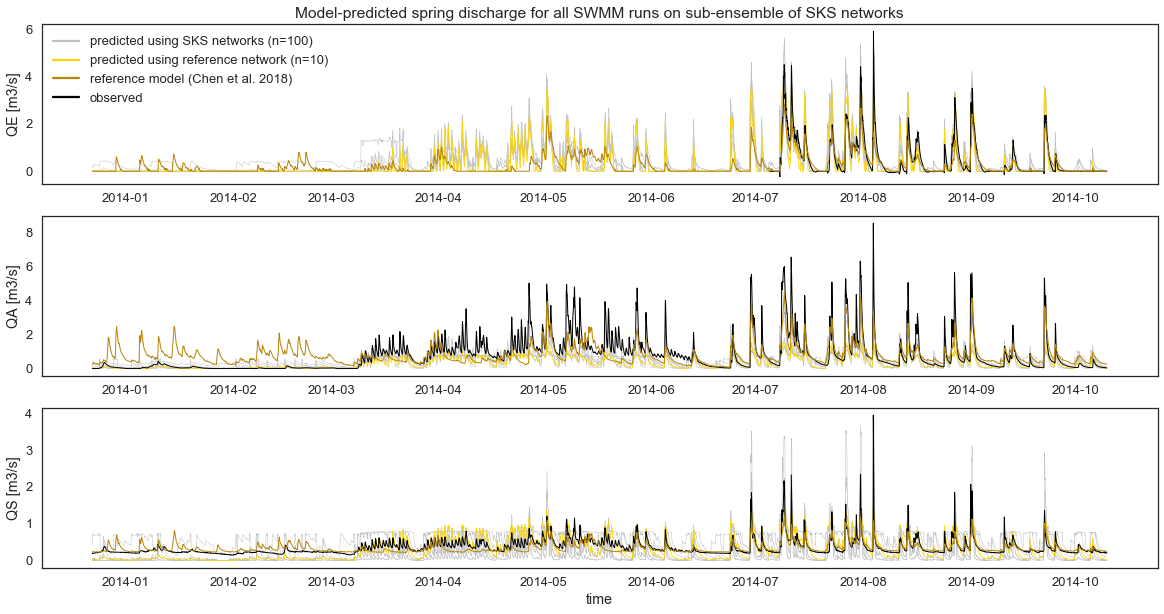

In [13]:
# Spring discharge timeseries for sub-ensemble (10 SWMM runs x 10 SKS runs)

#Set up figure:
f = plt.figure(figsize=(20,10))                         #create figure to plot on
ax=[plt.subplot(311),plt.subplot(312),plt.subplot(313)] #create subplots for spring Q
ax[0].set_ylabel('QE [m3/s]')                                  #set plot y labels
ax[1].set_ylabel('QA [m3/s]')
ax[2].set_ylabel('QS [m3/s]')
ax[0].set_title('Model-predicted spring discharge for all SWMM runs on sub-ensemble of SKS networks')
ax[2].set_xlabel('time')

#Loop over SWMM runs on SKS sub-ensemble networks & plot: 
gpRunID = gpIDs[0]
for k,swmmRunID in enumerate(subset):           #loop over SWMM subset of 10 behavioral runs
    sksRunID = swmmRunID[:len(sksIDs[0])]
    index      = (gpRunID,sksRunID,swmmRunID)           #set index for data storage
    plotQ(data.loc[index, 'Q'], c='silver', lw=0.5)             #plot each SWMM run
#Loop over SWMM runs on reference network & plot:
for k,swmmRunID in enumerate(subsetRef):           #loop over SWMM subset of 10 behavioral runs
    index      = ('base','base',swmmRunID)           #set index for data storage
    plotQ(data.loc[index, 'Q'], c='gold', lw=0.5)             #plot each SWMM run
#Plot observed & reference model timeseries:
plotQ(data.loc[('obs','0','0'), 'Q'], c='k')                #plot observed flow
plotQ(Qbase, c='darkgoldenrod')                             #plot reference model flow

#Format legend:
ax[0].legend((matplotlib.lines.Line2D([0],[0], color='silver'),
              matplotlib.lines.Line2D([0],[0], color='gold'),
              matplotlib.lines.Line2D([0],[0], color='darkgoldenrod'), 
              matplotlib.lines.Line2D([0],[0], color='k')),
             ('predicted using SKS networks (n=100)', 'predicted using reference network (n=10)', 
              'reference model (Chen et al. 2018)', 'observed'))

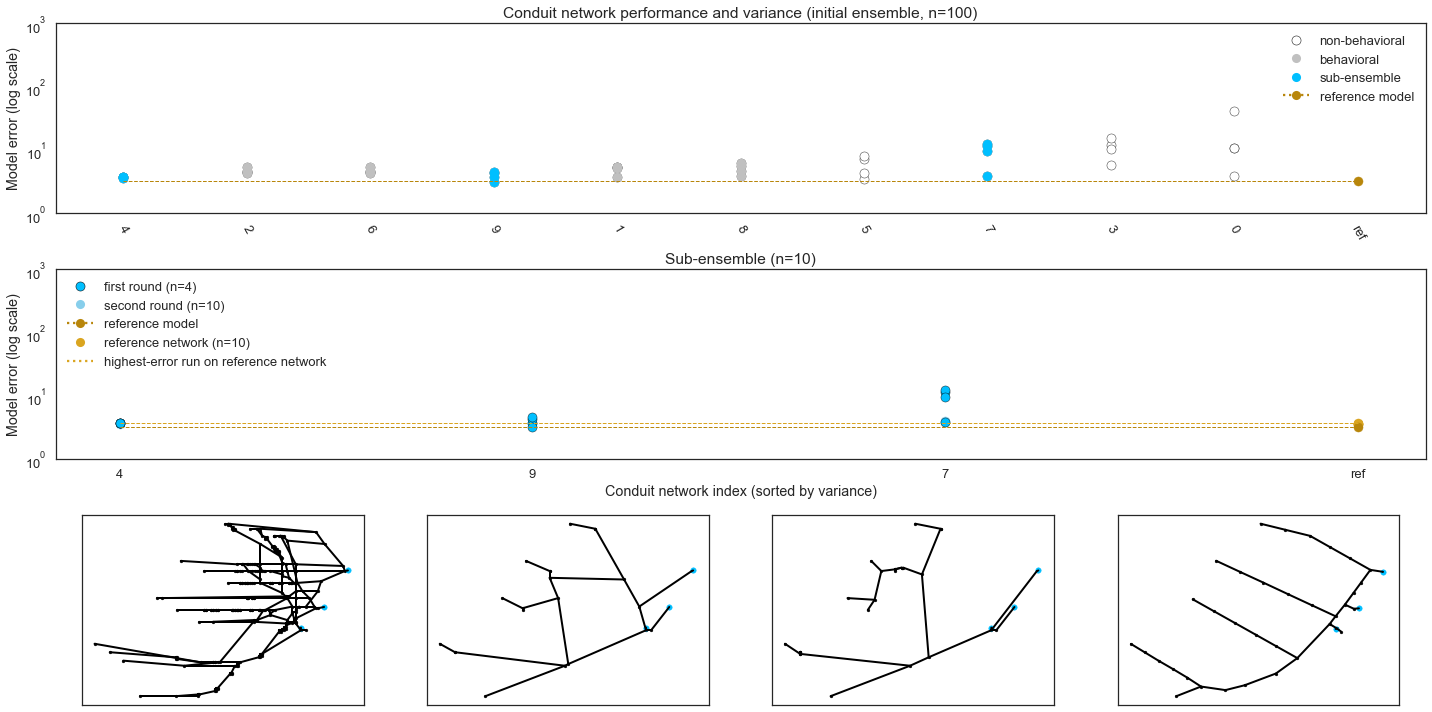

In [19]:
#Dotplot of model error ranked by variance
######################
#Set up data:
#get all first-round data that will be plotted, with correct ordering and indices, and put it all in one dataframe
names = [sksIDs[j]+'swmmR1_'+restrictBehavior[k] for k in range(nruns['swmmRound1'][0]) for j in range(nruns['sks'][0])]  #get list of names of swmm runs in round 1
fit = pd.DataFrame(index=names, columns=['sksRunID','ind', 'fit','behavioral','subensemble','stdev']) #create empty dataframe
for j in range(nruns['sks'][0]):                #loop over all SKS runs for first round
    sksRunID = sksIDs[j]                        #get SKS ID for current run
    #Round 1:
    for k in range(nruns['swmmRound1'][0]):     #loop over SWMM runs (round 1)
        swmmRunID = sksRunID + 'swmmR1_' + restrictBehavior[k]      #create run ID string (round 1)
        fit.loc[swmmRunID,'sksRunID'] = sksRunID                    #store SKS ID
        fit.loc[swmmRunID,'ind']      = j                           #store SKS index
        fit.loc[swmmRunID,'fit']      = np.sum([stats.loc[(spring, 'RMSE'), swmmRunID]/np.mean(Qobs[spring]) for spring in springs]) #calculate sum of RMSE at each spring normalized by mean observed discharge at that spring
        if sksRunID in sksIDsB:                                     #for behavioral SKS runs
            fit.loc[swmmRunID,'behavioral'] = True                  #store that they were behavioral
        else:                                         
            fit.loc[swmmRunID,'behavioral'] = False
        if sksRunID in subEnsemble:                                 #for SKS runs chosen for sub-ensemble
            fit.loc[swmmRunID,'subensemble'] = True                 #store that they were chosen
        else:
            fit.loc[swmmRunID,'subensemble'] = False
    #Round 2:
    if sksRunID in subEnsemble:                         #for SKS networks in subensemble 
        for k in range(nruns['swmm'][0]):               #loop over SWMM runs (round 2)
            swmmRunID = sksRunID + 'swmm' + str(k)      #create ID string
            fit.loc[swmmRunID,'sksRunID'] = sksRunID    #store SKS ID
            fit.loc[swmmRunID,'ind']      = j           #store SKS index
            fit.loc[swmmRunID,'fit']      = np.sum([stats.loc[(spring, 'RMSE'), swmmRunID]/np.mean(Qobs[spring]) for spring in springs]) #calculate sum of RMSE at each spring normalized by mean observed discharge at that spring
#Reference:
fit.loc['base','fit']  = np.sum([stats.loc[(spring, 'RMSE'), 'base']/np.mean(Qobs[spring]) for spring in springs])  #calculate overall fit metric for base network
for k in range(nruns['swmm'][0]):               #loop over SWMM runs (round 2)
    swmmRunID = 'base' + 'swmm' + str(k)        #create ID string
    fit.loc[swmmRunID,'fit']      = np.sum([stats.loc[(spring, 'RMSE'), swmmRunID]/np.mean(Qobs[spring]) for spring in springs]) #calculate sum of RMSE at each spring normalized by mean observed discharge at that spring

#Normalize fit metric & calculate stdev across all SWMM runs for each SKS run:
fit['norm']  = (fit.fit - np.min(fit.fit)) / (np.max(fit.fit) - np.min(fit.fit)) #normalize data to be between 0 and 1 for color mapping
for j in range(nruns['sks'][0]):
    sksRunID = sksIDs[j]
    swmmRunIDs = [sksRunID + 'swmmR1_'+ restrictBehavior[k] for k in range(nruns['swmmRound1'][0])] #get list of names of SWMM runs for current SKS run
    fit.loc[swmmRunIDs, 'stdev'] = np.std(fit.loc[swmmRunIDs,'fit']) #calculate & store std. deviation of normalized fit

#Save unsorted order, sort, and save sorting order:
iSubEnsemble         = pd.unique(fit.ind[fit.subensemble==True])
fit.sort_values(by=['stdev','norm'], inplace=True)                    #sort by std.dev. and then by normalized fit
iSubEnsemble_sortStd = pd.unique(fit.ind[fit.subensemble==True])
subEnsemble_sortStd  = pd.unique(fit.sksRunID[fit.subensemble==True])

###############################
#Set up figure:
f    = plt.figure(figsize=(20,10), tight_layout=True)        #create empty figure
gs   = matplotlib.gridspec.GridSpec(3, len(subEnsemble)+1)   #set up grid with nrows, ncols
ax0  = f.add_subplot(gs[0, :])                #add a subplot in first row, spanning all columns
ax1  = f.add_subplot(gs[1, :])                #add a subplot in first row, spanning all columns
ax0.set_title('Conduit network performance and variance (initial ensemble, n=100)')
ax0.set_yscale('log')
ax1.set_yscale('log')
ax0.set_ylim(ymin=1,ymax=1000)
ax1.set_ylim(ymin=1,ymax=1000)

#For entire ensemble:
ax0.plot([0,nruns['sks'][0]],[fit.loc['base','fit'],fit.loc['base','fit']], ls='--', lw=1, c='darkgoldenrod') #plot reference line

for j, sksRunID in enumerate(pd.unique(fit.sksRunID[~pd.isnull(fit.sksRunID)])): #loop over all non-nan SKS runs
    swmmRunIDs = [sksRunID + 'swmmR1_' + restrictBehavior[k] for k in range(nruns['swmmRound1'][0])] #get list of 1st-round swmm run names for current SKS network
    ax0.scatter(np.full(nruns['swmmRound1'][0],j), fit.loc[swmmRunIDs,'fit'], facecolors='w', edgecolors='k') #plot error distribution for each SKS run
    #Highlight behavioral SKS networks:
    if fit.loc[swmmRunIDs[0],'behavioral'] == True:
        ax0.scatter(np.full(nruns['swmmRound1'][0],j), fit.loc[swmmRunIDs,'fit'], c='silver') #plot error distribution for each SKS run
    #Highlight sub-ensemble of SKS networks:
    if fit.loc[swmmRunIDs[0],'subensemble'] == True:
        ax0.scatter(np.full(nruns['swmmRound1'][0],j), fit.loc[swmmRunIDs,'fit'], c='deepskyblue') #plot error distribution for each SKS run
#Add reference model:
ax0.scatter(nruns['sks'][0], fit.loc['base','fit'], c='darkgoldenrod') 
#Format axes:
xlabels = np.append(pd.unique(fit.ind[~pd.isnull(fit.ind)]), 'ref')
ax0.set_xticks(np.arange(0, len(sksIDs)+1, 1))
ax0.set_xticklabels(xlabels, rotation=-60)
ax0.set_ylabel('Model error (log scale)')
#ax0.set_xlabel('Conduit network index (sorted by variance)')
ax0.legend([matplotlib.lines.Line2D([0],[0], mec='k', mfc='white', mew=0.5, marker='o', linestyle='None'),
            matplotlib.lines.Line2D([0],[0], color='silver', marker='o', linestyle='None'),
            matplotlib.lines.Line2D([0],[0], color='deepskyblue', marker='o', linestyle='None'),
            matplotlib.lines.Line2D([0],[0], color='darkgoldenrod', marker='o', linestyle=':')],
           ['non-behavioral','behavioral','sub-ensemble','reference model'])

#################################
#Sub-ensemble:
for j, sksRunID in enumerate(pd.unique(fit.sksRunID[fit.subensemble==True])):
    #For Round 2 (n=20):
    #swmmRunIDs = [sksRunID + 'swmm' + str(k) for k in range(nruns['swmm'][0])]
    #ax1.scatter(np.full(nruns['swmm'][0],j), fit.loc[swmmRunIDs,'fit'], c='skyblue') #plot error distribution for each SKS run    
    
    #For Round 2 subset (n=10 behavioral):
    swmmRunIDs = [sksRunID + 'swmm' + str(k) for k in range(nruns['swmm'][0])] #get list of swmm IDs for current SKS run
    swmmRunIDs = [swmmRunID for swmmRunID in swmmRunIDs if swmmRunID in subset]              #select only those in the smaller behavioral subset of 10
    ax1.scatter(np.full(len(swmmRunIDs),j), fit.loc[swmmRunIDs,'fit'], c='skyblue') #plot error distribution for each SKS run    
    
    #For Round 1:
    swmmRunIDs = [sksRunID + 'swmmR1_' + restrictBehavior[k] for k in range(nruns['swmmRound1'][0])]
    ax1.scatter(np.full(nruns['swmmRound1'][0],j), fit.loc[swmmRunIDs,'fit'], c='deepskyblue', edgecolors='k') #plot error distribution for each SKS run    
#Add reference model:
swmmRunIDs = ['base' + 'swmm' + str(k) for k in range(nruns['swmm'][0])] #get list of names of SWMM runs on base network
ax1.scatter(np.full(nruns['swmm'][0], len(subEnsemble)), fit.loc[swmmRunIDs,'fit'], c='goldenrod') #plot SWMM runs on base network
ax1.scatter(len(subEnsemble), fit.loc['base','fit'], c='darkgoldenrod') #plot Zhao's model
#Lines:
ax1.plot([0,len(subEnsemble)], [fit.loc['base','fit'],fit.loc['base','fit']], ls='--', lw=1, c='darkgoldenrod') #plot reference line
refmax = max(fit.loc[swmmRunIDs,'fit']) #get max error for SWMM runs on reference network
ax1.plot([0,len(subEnsemble)], [refmax,refmax], ls='--', lw=1, c='goldenrod')  #plot as line
#ref15  = fit.loc['base','fit'] + 0.15*fit.loc['base','fit']   #get 15% bound
#ax1.plot([0,len(subEnsemble)], [ref15,ref15], ls='--', lw=1, c='gold') #plot as line

#Format axes:
ax1.set_title('Sub-ensemble (n=10)')
ax1.set_xticks(np.arange(0, len(subEnsemble)+1, 1.0))
ax1.set_xticklabels(labels=np.append(pd.unique(fit.ind[fit.subensemble==True]),'ref'))
ax1.set_ylabel('Model error (log scale)')
ax1.set_xlabel('Conduit network index (sorted by variance)')
ax1.legend([matplotlib.lines.Line2D([0],[0], mec='k', mfc='deepskyblue', mew=0.5, marker='o', linestyle='None'),
            matplotlib.lines.Line2D([0],[0], color='skyblue', marker='o', linestyle='None'),
            matplotlib.lines.Line2D([0],[0], color='darkgoldenrod', marker='o', linestyle=':'),
            matplotlib.lines.Line2D([0],[0], color='goldenrod', marker='o', linestyle='None'),
            matplotlib.lines.Line2D([0],[0], color='goldenrod', marker=None, linestyle=':')],
           ['first round (n=4)','second round (n=10)','reference model', 
            'reference network (n=10)', 'highest-error run on reference network'],
            loc='upper left')

################################
#Network maps:
for j, sksRunID in enumerate(pd.unique(fit.sksRunID[fit.subensemble==True])):
    ax3 = f.add_subplot(gs[-1, j], aspect='equal')      #add subplot to last row, current column
    nodes = nodesAll.loc['simple',sksRunID]             #retrieve current network geometry
    links = linksAll.loc['simple',sksRunID]
    sp.plot_map(nodes,links, dim=2, fig=f, ax=ax3)      #plot each individual simple conduit map
    ax3.get_xaxis().set_visible(False)                  #hide axis ticks & labels
    ax3.get_yaxis().set_visible(False)
#Reference model:
ax3 = f.add_subplot(gs[-1, len(subEnsemble)], aspect='equal')      #add subplot to last row, last column
sp.plot_map(base_nodes,base_links, dim=2, fig=f, ax=ax3)            #plot reference conduit map
ax3.get_xaxis().set_visible(False)                                  #hide axis ticks & labels
ax3.get_yaxis().set_visible(False)


In [15]:
#Calculate the percentage of SWMM-SKS runs within 10% error of the reference model:
#Reference model fit:
ref = fit.loc['base','fit']

#SWMM runs on reference network fit:
swmmRunIDs = ['base' + 'swmm' + str(k) for k in range(nruns['swmm'][0])] #get list of names of SWMM runs on base network
swmmRunIDs = [swmmRunID for swmmRunID in swmmRunIDs if swmmRunID in subsetRef]              #select only those in the smaller behavioral subset of 10
refSWMM = fit.loc[swmmRunIDs,'fit']

#SWMM runs on SKS networks fit (round 2):
swmmRunIDsR2 = []
for j, sksRunID in enumerate(pd.unique(fit.sksRunID[fit.subensemble==True])):
    swmmRunIDs = [sksRunID + 'swmm' + str(k) for k in range(nruns['swmm'][0])] #get list of swmm IDs for current SKS run
    swmmRunIDs = [swmmRunID for swmmRunID in swmmRunIDs if swmmRunID in subset]              #select only those in the smaller behavioral subset of 10
    swmmRunIDsR2.append(swmmRunIDs)
swmmRunIDsR2 = [item for sublist in swmmRunIDsR2 for item in sublist]
SWMM = fit.loc[swmmRunIDsR2,'fit'] 
    
print('Reference model global error:\t', ref)
#print('\nSWMM runs on reference network fits:\t', refSWMM.values)
#print('\nSWMM runs on SKS networks fits:\t', SWMM.values)

#How many are close?
threshold = 0.15
refSWMMclose = refSWMM[abs(refSWMM - ref) < (threshold*ref)]
SWMMclose    = SWMM[abs(SWMM - ref) < (threshold*ref)]

print('\nSWMM runs on reference network within',threshold,'of reference error (n=', len(refSWMMclose),'):\n', refSWMMclose)
print('\nSWMM runs on SKS networks within',threshold,'of reference error (n=', len(SWMMclose), '):\n', SWMMclose)


Reference model global error:	 3.2603384019061514

SWMM runs on reference network within 0.15 of reference error (n= 2 ):
 baseswmm0    3.62042
baseswmm3    3.59491
Name: fit, dtype: object

SWMM runs on SKS networks within 0.15 of reference error (n= 4 ):
 testgp01020sks102210011756111110002swmm0    3.63775
testgp01020sks102210011756111110002swmm2    3.58913
testgp01020sks162110011852000000002swmm0    3.66626
testgp01020sks162110011852000000002swmm1    3.66626
Name: fit, dtype: object


done calculating distance matrix


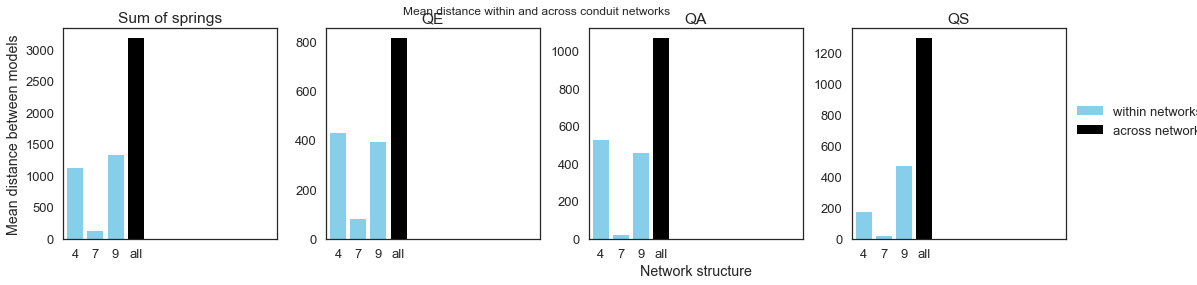

In [20]:
#Calculate within-network vs. across-network contributions to uncertainty using distance matrix approach:

#Set up storage matrix as a multi-indexed dataframe:
index = pd.MultiIndex.from_tuples([('base','base')], names=['network','pars'])
SSD = pd.DataFrame(columns=index, index=index, dtype='object')
SSDQE = pd.DataFrame(columns=index, index=index, dtype='object')
SSDQA = pd.DataFrame(columns=index, index=index, dtype='object')
SSDQS = pd.DataFrame(columns=index, index=index, dtype='object')

#Loop over every possible pairing of models:
runs = subset.copy()   #make a copy of the subset of models being considered (to not mess up original)
include_ref = False    #turn on to consider the reference models
if include_ref == True:
    for swmmRunID in subsetRef:  #add in the runs on the reference network
        runs.append(swmmRunID)
    runs.append('base')          #add in the reference model
#combinations = list(itertools.combinations(subset, 2)) #get list of all possible combinations of pairs of models (n choose k)
combinations = list(itertools.combinations(runs, 2))   #get list of all possible combinations of pairs of models (n choose k)

for pair in combinations:                          #loop over pairs
    #Set up indexing & extract timeseries:
    swmmRunID1 = pair[0]                           #get swmm run ID for first model in pair
    if 'base' in swmmRunID1:                       #for the reference models
        gpRunID1   = 'base'
        sksRunID1  = 'base'
    else:
        gpRunID1   = swmmRunID1[:len(gpIDs[0])]     #get gempy run ID for first model in pair
        sksRunID1  = swmmRunID1[:len(sksIDs[0])]    #get sks run ID for first model in pair
    index1 = (gpRunID1, sksRunID1, swmmRunID1)      #make index to retrieve data from storage df
    Q1 = data.loc[index1,'Q']                       #retrieve data for first model in pair
    
    swmmRunID2 = pair[1]                            #get swmm run ID for second model in pair
    if 'base' in swmmRunID2:                        #for the reference models
        gpRunID2   = 'base'
        sksRunID2  = 'base'
    else:
        gpRunID2   = swmmRunID2[:len(gpIDs[0])]     #get gempy run ID for second model in pair
        sksRunID2  = swmmRunID2[:len(sksIDs[0])]    #get sks run ID for second model in pair
    index2 = (gpRunID2, sksRunID2, swmmRunID2)      #make index to retrieve data from storage df
    Q2 = data.loc[index2,'Q']                       #retrieve data for second model in pair
    
    #Rescale discharge timeseries by dividing each measurement by the mean observed discharge at that spring:
    #for spring in springs:
        #Q1[spring] = Q1[spring] / np.mean(Qobs[spring])
        #Q2[spring] = Q2[spring] / np.mean(Qobs[spring])
    
    #Calculate sum of squared differences (i.e. how far apart are the two models?):
    ssdQE = np.sum((Q1.QE - Q2.QE)**2)      
    ssdQA = np.sum((Q1.QA - Q2.QA)**2)
    ssdQS = np.sum((Q1.QS - Q2.QS)**2)
    ssd = ssdQE + ssdQA + ssdQS               #sum SSD for all three springs
    SSD.at[(sksRunID1,swmmRunID1),(sksRunID2,swmmRunID2)] = ssd   #store summed SSD for current pair of models in the matrix of all SSDs
    SSDQE.at[(sksRunID1,swmmRunID1),(sksRunID2,swmmRunID2)] = ssdQE   #store QE SSD for current pair of models in the matrix of QE SSDs
    SSDQA.at[(sksRunID1,swmmRunID1),(sksRunID2,swmmRunID2)] = ssdQA   #store QA SSD for current pair of models in the matrix of QA SSDs
    SSDQS.at[(sksRunID1,swmmRunID1),(sksRunID2,swmmRunID2)] = ssdQS   #store QS SSD for current pair of models in the matrix of QS SSDs


SSD.drop(index=('base','base'), columns=('base','base'), inplace=True)
SSDQE.drop(index=('base','base'), columns=('base','base'), inplace=True)
SSDQA.drop(index=('base','base'), columns=('base','base'), inplace=True)
SSDQS.drop(index=('base','base'), columns=('base','base'), inplace=True)
print('done calculating distance matrix')

############################################
#Calculate average distance between parameter sets within the same network:
#inNetwork = pd.DataFrame(index=subEnsemble, columns=['meanSSD'])
inNetwork = pd.DataFrame(index=subEnsemble, columns=['sumSSD', 'QE', 'QA', 'QS'])
for sksRunID in subEnsemble:                                                   #loop over networks
    struct = SSD.xs(sksRunID, axis='index', level='network').xs(sksRunID, axis='columns', level='network') #get subset of SSDs between parameter sets on current network
    inNetwork.loc[sksRunID, 'sumSSD'] = np.mean(struct.values[~np.isnan(struct)])  #calculate mean distance between parameter sets on current network structure
    struct = SSDQE.xs(sksRunID, axis='index', level='network').xs(sksRunID, axis='columns', level='network') #get subset of SSDs between parameter sets on current network
    inNetwork.loc[sksRunID, 'QE'] = np.mean(struct.values[~np.isnan(struct)])  #calculate mean distance between parameter sets on current network structure
    struct = SSDQA.xs(sksRunID, axis='index', level='network').xs(sksRunID, axis='columns', level='network') #get subset of SSDs between parameter sets on current network
    inNetwork.loc[sksRunID, 'QA'] = np.mean(struct.values[~np.isnan(struct)])  #calculate mean distance between parameter sets on current network structure
    struct = SSDQS.xs(sksRunID, axis='index', level='network').xs(sksRunID, axis='columns', level='network') #get subset of SSDs between parameter sets on current network
    inNetwork.loc[sksRunID, 'QS'] = np.mean(struct.values[~np.isnan(struct)])  #calculate mean distance between parameter sets on current network structure

#Calculate average distance between networks:
xNetworkAvg = pd.DataFrame(index=['dist'], columns=['sumSSD', 'QE', 'QA', 'QS'])  #set up empty df avg. dist between structures for each spring
xNetwork   = pd.DataFrame(index=subEnsemble, columns=subEnsemble)                  #set up emtpy df for avg. dist between pairs of structures for sum of springs
xNetworkQE = pd.DataFrame(index=subEnsemble, columns=subEnsemble)                  #and for each spring
xNetworkQA = pd.DataFrame(index=subEnsemble, columns=subEnsemble)                  
xNetworkQS = pd.DataFrame(index=subEnsemble, columns=subEnsemble)                

combinations = list(itertools.combinations(subEnsemble, 2))     #get list of all possible combinations of pairs of networks (n choose k)
for pair in combinations:                                       #loop over pairs
    sksRunID1 = pair[0]
    swmmRunIDs1 = [swmmRunID for swmmRunID in subset if sksRunID1 in swmmRunID] #get all SWMM run IDs being considered for the current network
    sksRunID2 = pair[1]
    swmmRunIDs2 = [swmmRunID for swmmRunID in subset if sksRunID2 in swmmRunID] #get all SWMM run IDs being considered for the current network
    #For sum of SSD at all three springs:
    dist = SSD.loc[(sksRunID1,swmmRunIDs1), (sksRunID2,swmmRunIDs2)]
    if np.unique(pd.isnull(dist)):                                              #if array is empty
        dist = SSD.loc[(sksRunID2,swmmRunIDs2), (sksRunID1,swmmRunIDs1)]        #flip the pair order
    xNetwork.loc[sksRunID1,sksRunID2] = np.nanmean(dist.values)                 #take avg. SSD between each model on structure 1 and each model on structure 2 in pair
    #For QE:
    dist = SSDQE.loc[(sksRunID1,swmmRunIDs1), (sksRunID2,swmmRunIDs2)]
    if np.unique(pd.isnull(dist)):                                              #if array is empty
        dist = SSDQE.loc[(sksRunID2,swmmRunIDs2), (sksRunID1,swmmRunIDs1)]        #flip the pair order
    xNetworkQE.loc[sksRunID1,sksRunID2] = np.nanmean(dist.values)                 #take avg. SSD between each model on structure 1 and each model on structure 2 in pair
    #For QA:
    dist = SSDQA.loc[(sksRunID1,swmmRunIDs1), (sksRunID2,swmmRunIDs2)]
    if np.unique(pd.isnull(dist)):                                              #if array is empty
        dist = SSDQA.loc[(sksRunID2,swmmRunIDs2), (sksRunID1,swmmRunIDs1)]        #flip the pair order
    xNetworkQA.loc[sksRunID1,sksRunID2] = np.nanmean(dist.values)                 #take avg. SSD between each model on structure 1 and each model on structure 2 in pair
    #For QS:
    dist = SSDQS.loc[(sksRunID1,swmmRunIDs1), (sksRunID2,swmmRunIDs2)]
    if np.unique(pd.isnull(dist)):                                              #if array is empty
        dist = SSDQS.loc[(sksRunID2,swmmRunIDs2), (sksRunID1,swmmRunIDs1)]        #flip the pair order
    xNetworkQS.loc[sksRunID1,sksRunID2] = np.nanmean(dist.values)                 #take avg. SSD between each model on structure 1 and each model on structure 2 in pair

#Now you have an array of the distance between each pair of network structures.
#To find the average distance between structures, take the mean of all the distances between pairs:
xNetworkAvg.sumSSD = np.nanmean(xNetwork.values)  #take avg. of distances between pairs of structures - this is the average distance between structures
xNetworkAvg.QE     = np.nanmean(xNetworkQE.values)  #take avg. of distances between pairs of structures - this is the average distance between structures
xNetworkAvg.QA     = np.nanmean(xNetworkQA.values)  #take avg. of distances between pairs of structures - this is the average distance between structures
xNetworkAvg.QS     = np.nanmean(xNetworkQS.values)  #take avg. of distances between pairs of structures - this is the average distance between structures

##############################################################
#Bar plot average distances within networks vs. across networks:
f,ax = plt.subplots(1,4, figsize=(15,4), tight_layout=True)
ax[0].bar(np.arange(len(subEnsemble)), inNetwork.sumSSD,   color='skyblue', tick_label=iSubEnsemble)
ax[0].bar(len(subEnsemble),            xNetworkAvg.sumSSD, color='k')
ax[0].set_title('Sum of springs')
ax[1].bar(np.arange(len(subEnsemble)), inNetwork.QE,   color='skyblue', tick_label=iSubEnsemble)
ax[1].bar(len(subEnsemble),            xNetworkAvg.QE, color='k',       tick_label='all')
ax[1].set_title('QE')
ax[2].bar(np.arange(len(subEnsemble)), inNetwork.QA,   color='skyblue', tick_label=iSubEnsemble)
ax[2].bar(len(subEnsemble),            xNetworkAvg.QA, color='k',       tick_label='all')
ax[2].set_title('QA')
ax[3].bar(np.arange(len(subEnsemble)), inNetwork.QS,   color='skyblue', tick_label=iSubEnsemble)
ax[3].bar(len(subEnsemble),            xNetworkAvg.QS, color='k',       tick_label='all')
ax[3].set_title('QS')
ax[0].set_ylabel('Mean distance between models')
ax[2].set_xlabel('Network structure')
f.suptitle('Mean distance within and across conduit networks')
f.legend(['within networks (n = 10)', 'across networks (mean) (n=10)'], loc=(0.895,0.5))
#Format ticks:
for i in range(len(ax)):
    ax[i].set_xticks(np.arange(11))
    ax[i].set_xticklabels(list(np.append(iSubEnsemble,'all')))


In [21]:
#Set up data for Q plot:
#get subset of data that will be plotted, with correct ordering and indices, and put it all in one dataframe
names = [sksIDs[j]+'swmm'+str(k) for k in range(len(subEnsemble)) for j in range(nruns['sks'][0])]  #get list of names of swmm runs in round 1
fit = pd.DataFrame(index=['base'], columns=['sksRunID','ind', 'fit','subset']) #create empty dataframe
for j in range(nruns['sks'][0]):                #loop over all SKS runs for first round
    sksRunID = sksIDs[j]                        #get SKS ID for current run
    if sksRunID in subEnsemble:                         #for SKS networks in subensemble 
        for k in range(nruns['swmm'][0]):               #loop over SWMM runs (round 2)
            swmmRunID = sksRunID + 'swmm' + str(k)      #create ID string
            if swmmRunID in subset:                         #for SWMM runs in subset
                fit.loc[swmmRunID,'sksRunID'] = sksRunID    #store SKS ID
                fit.loc[swmmRunID,'ind']      = j           #store SKS index
                fit.loc[swmmRunID,'subset']   = True        #flag as part of subset
                fit.loc[swmmRunID,'fit']      = np.sum([stats.loc[(spring, 'RMSE'), swmmRunID]/np.mean(Qobs[spring]) for spring in springs]) #calculate sum of RMSE at each spring normalized by mean observed discharge at that spring
#Reference:
fit.loc['base','fit']  = np.sum([stats.loc[(spring, 'RMSE'), 'base']/np.mean(Qobs[spring]) for spring in springs])  #calculate overall fit metric for base network
for k in range(nruns['swmm'][0]):               #loop over SWMM runs (round 2)
    swmmRunID = 'base' + 'swmm' + str(k)        #create ID string
    if swmmRunID in subsetRef:                  #for SWMM runs in subset
        fit.loc[swmmRunID,'fit'] = np.sum([stats.loc[(spring, 'RMSE'), swmmRunID]/np.mean(Qobs[spring]) for spring in springs]) #calculate sum of RMSE at each spring normalized by mean observed discharge at that spring
        fit.loc[swmmRunID,'ind'] = 'base'
#Normalize fit metric, and sort by fit within each network:
fit['norm']  = (fit.fit - np.min(fit.fit)) / (np.max(fit.fit) - np.min(fit.fit)) #normalize data to be between 0 and 1 for color mapping
fit.sort_values(by=['ind','norm'], inplace=True)                    #sort by SKS network and then by normalized fit
iSubEnsemble_sortfit = pd.unique(fit.ind[fit.subset==True])         #save sorting order
subEnsemble_sortfit  = pd.unique(fit.sksRunID[fit.subset==True])    #save sorted IDs
swmmRunIDsBest = [fit.index[fit.ind==ind][0] for ind in pd.unique(fit.ind[~pd.isnull(fit.ind)])] #save best SWMM run for each network



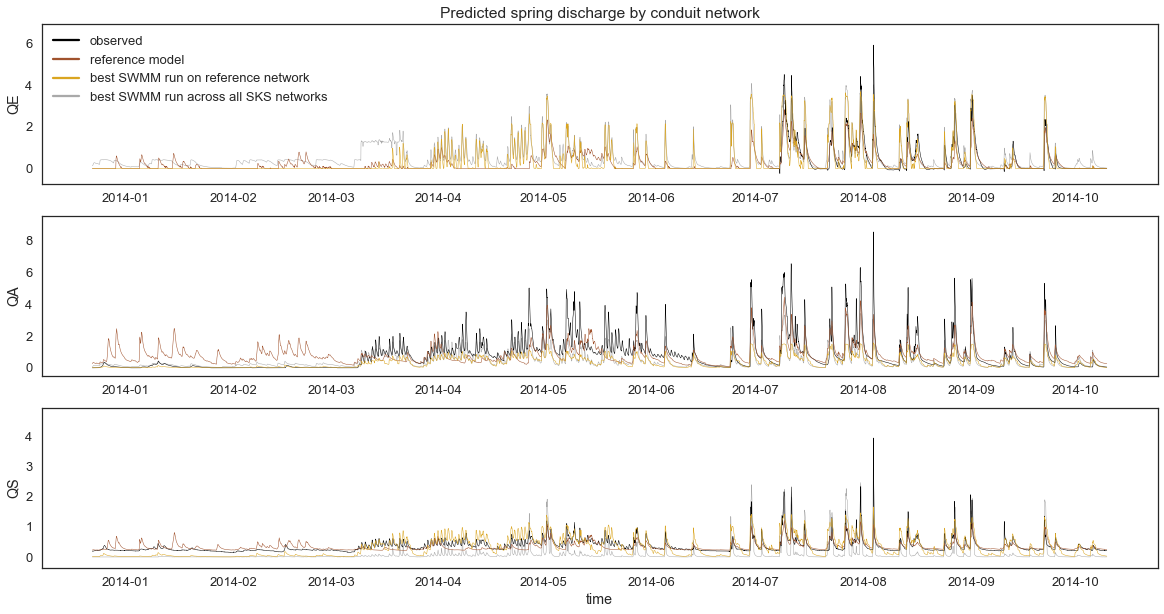

In [22]:
#Plot spring discharge timeseries for best-performing SWMM run for each network
#Get data to identify best runs:
#get subset of data that will be plotted, with correct ordering and indices, and put it all in one dataframe
names = [sksIDs[j]+'swmm'+str(k) for k in range(len(subEnsemble)) for j in range(nruns['sks'][0])]  #get list of names of swmm runs in round 1
fit = pd.DataFrame(index=['base'], columns=['sksRunID','ind', 'fit','subset']) #create empty dataframe
for j in range(nruns['sks'][0]):                #loop over all SKS runs for first round
    sksRunID = sksIDs[j]                        #get SKS ID for current run
    if sksRunID in subEnsemble:                         #for SKS networks in subensemble 
        for k in range(nruns['swmm'][0]):               #loop over SWMM runs (round 2)
            swmmRunID = sksRunID + 'swmm' + str(k)      #create ID string
            if swmmRunID in subset:                         #for SWMM runs in subset
                fit.loc[swmmRunID,'sksRunID'] = sksRunID    #store SKS ID
                fit.loc[swmmRunID,'ind']      = j           #store SKS index
                fit.loc[swmmRunID,'subset']   = True        #flag as part of subset
                fit.loc[swmmRunID,'fit']      = np.sum([stats.loc[(spring, 'RMSE'), swmmRunID]/np.mean(Qobs[spring]) for spring in springs]) #calculate sum of RMSE at each spring normalized by mean observed discharge at that spring
#Reference:
fit.loc['base','fit']  = np.sum([stats.loc[(spring, 'RMSE'), 'base']/np.mean(Qobs[spring]) for spring in springs])  #calculate overall fit metric for base network
fit.loc['base','ind']  = 'base'
for k in range(nruns['swmm'][0]):               #loop over SWMM runs (round 2)
    swmmRunID = 'base' + 'swmm' + str(k)        #create ID string
    if swmmRunID in subsetRef:                  #for SWMM runs in subset
        fit.loc[swmmRunID,'fit'] = np.sum([stats.loc[(spring, 'RMSE'), swmmRunID]/np.mean(Qobs[spring]) for spring in springs]) #calculate sum of RMSE at each spring normalized by mean observed discharge at that spring
        fit.loc[swmmRunID,'ind'] = 'base'
        fit.loc[swmmRunID, 'sksRunID'] = 'base'
#Normalize fit metric, and sort by fit within each network:
fit['norm']  = (fit.fit - np.min(fit.fit)) / (np.max(fit.fit) - np.min(fit.fit)) #normalize data to be between 0 and 1 for color mapping
fit.sort_values(by=['ind','norm'], inplace=True)                    #sort by SKS network and then by normalized fit
swmmRunIDsBest = [fit.index[fit.ind==ind][0] for ind in pd.unique(fit.ind[fit.ind != 'base'])] #save best SWMM run for each network
baseBest       = fit.index[fit.sksRunID=='base'][0]                 #find best run on reference network
best = fit.index[(fit.fit==np.min(fit.fit[fit.ind != 'base']))][0]  #find best SWMM run among all SKS networks

#Set up figure:
f = plt.figure(figsize=(20,10))                         #create figure to plot on
ax=[plt.subplot(311),plt.subplot(312),plt.subplot(313)] #create subplots for spring Q
ax[0].set_ylabel('QE')                                  #set plot y labels
ax[1].set_ylabel('QA')
ax[2].set_ylabel('QS')
ax[0].set_title('Predicted spring discharge by conduit network')
ax[2].set_xlabel('time')
ax[0].set_ylim(np.min(Qobs.QE)-0.5, np.max(Qobs.QE)+1)
ax[1].set_ylim(np.min(Qobs.QA)-0.5, np.max(Qobs.QA)+1)
ax[2].set_ylim(np.min(Qobs.QS)-0.5, np.max(Qobs.QS)+1)
cmap = matplotlib.cm.get_cmap('gray')                #get colormap object to select colors from
cmap = truncate_colormap(cmap, 0.3, 0.7)             #truncate colormap to avoid very light section
colors = np.linspace(0.1,1,len(subEnsemble))         #set up list of evenly-spaced color indices to use

#Loop over runs & plot:
for k,swmmRunID in enumerate(swmmRunIDsBest):                   #loop over best SWMM runs for each network (excluding base model)
    gpRunID  = swmmRunID[:len(gpIDs[0])]                #slice to get just the GemPy run id
    sksRunID = swmmRunID[:len(sksIDs[0])]
    index      = (gpRunID,sksRunID,swmmRunID)           #set index for data storage
    #plotQ(data.loc[(gpRunID,sksRunID,swmmRunID), 'Q'], c='silver', lw=0.5)          #plot each run
    #plotQ(data.loc[(gpRunID,sksRunID,swmmRunID), 'Q'], c=cmap(colors[k]), lw=0.5)   #plot each run with different colors
plotQ(data.loc[(best[:len(gpIDs[0])],best[:len(sksIDs[0])],best), 'Q'], c='darkgray', lw=0.5) #plot best of best SWMM runs on SKS networks
plotQ(data.loc[('obs','0','0'), 'Q'], c='k',lw=0.5)            #plot observed flow
plotQ(Qbase, c='sienna', lw=0.5)                         #plot reference model flow
plotQ(data.loc[('base','base',baseBest), 'Q'], c='goldenrod', lw=0.5) #plot best SWMM run on base network flow
ax[0].legend((matplotlib.lines.Line2D([0],[0], color='k'), 
              matplotlib.lines.Line2D([0],[0], color='sienna'),
              matplotlib.lines.Line2D([0],[0], color='goldenrod'),
              matplotlib.lines.Line2D([0],[0], color='darkgray')),
             ('observed', 'reference model', 'best SWMM run on reference network', 'best SWMM run across all SKS networks'))


[]

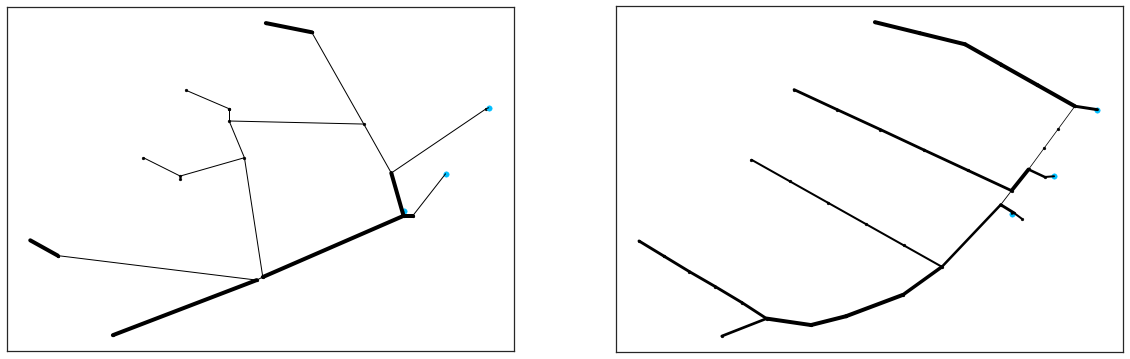

In [23]:
#Plot best SKS network (based on best SWMM run) compared to reference network:
f,ax = plt.subplots(1,2, figsize=(20,10))

#Best SKS network:
best_sksID = best[:len(sksIDs[0])]
nodes = nodesAll.loc['simple',sksRunID]     #retrieve current network geometry
links = linksAll.loc['simple',sksRunID]
diameters = data.loc[(gpIDs[0],best_sksID,best),'diameters']
linewidth = [d*0.5 for d in diameters]
sp.plot_map(nodes,links, dim=2, fig=f, ax=ax[0], lw=linewidth)  #plot each individual simple conduit map
ax[0].set_yticks([]) 
ax[0].set_xticks([])

#Reference network:
linewidth = [d*0.5 for d in baseDiameters]
sp.plot_map(base_nodes,base_links, dim=2, fig=f, ax=ax[1], lw=linewidth)  #plot each individual simple conduit map
ax[1].set_yticks([]) 
ax[1].set_xticks([])


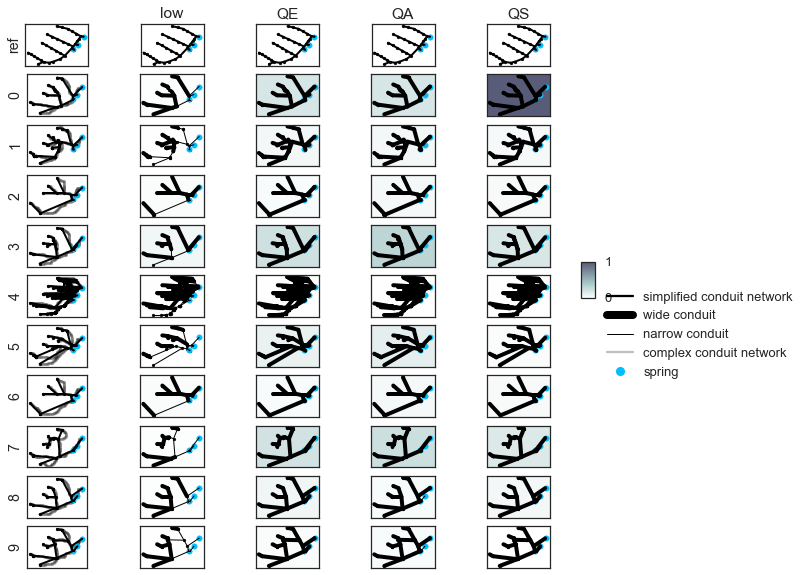

In [24]:
#Grid of all SKS conduit networks Round 1, performance under different restriction conditions

#Set up plot:
f = plt.figure(figsize=(10,nruns['sks'][0]))                 #create empty figure of (width, height)
gs   = matplotlib.gridspec.GridSpec(nruns['sks'][0]+1, 5)       #set up grid with (nrows, ncols)
cmap = matplotlib.cm.get_cmap('bone_r')         #get colormap object to select colors from ('bone_r')
cmap = truncate_colormap(cmap, 0.0, 0.6)        #truncate colormap to avoid very dark section
m    = matplotlib.cm.ScalarMappable(cmap=cmap)  #create mappable object for colorbar

#Set up data:
#get all first-round data that will be plotted, with correct ordering and indices, and put it all in one dataframe
names = [sksIDs[j]+'swmmR1_'+restrictBehavior[k] for k in range(nruns['swmmRound1'][0]) for j in range(nruns['sks'][0])]
fit = pd.DataFrame(index=names, columns=['sksRunID','ind', 'fit','behavioral','restrictBehavior','diameters']) #create empty dataframe
for j in range(nruns['sks'][0]):        #loop over all SKS runs for first round
    sksRunID = sksIDs[j]                #get SKS ID for current run
    for k in range(nruns['swmmRound1'][0]):    #loop over SWMM runs (round 1)
        swmmRunID = sksRunID + 'swmmR1_' + restrictBehavior[k]      #create run ID string (round 1)
        fit.loc[swmmRunID,'sksRunID'] = sksRunID
        fit.loc[swmmRunID,'ind']      = j
        fit.loc[swmmRunID,'fit']      = np.sum([stats.loc[(spring, 'RMSE'), swmmRunID]/np.mean(Qobs[spring]) for spring in springs]) #calculate sum of RMSE at each spring normalized by mean observed discharge at that spring
        fit.loc[swmmRunID,'restrictBehavior'] = restrictBehavior[k]
        fit.loc[swmmRunID,'diameters'] = data.loc[(gpRunID,sksRunID,swmmRunID),'diameters']
        if sksRunID in sksIDsB:
            fit.loc[swmmRunID,'behavioral'] = True
        else:
            fit.loc[swmmRunID,'behavioral'] = False
fit['norm'] = (fit.fit - np.min(fit.fit)) / (np.max(fit.fit) - np.min(fit.fit)) #normalize data to be between 0 and 1 for color mapping

#Plot reference network in first row:
ax = f.add_subplot(gs[0,0])             #add subplot in first row, first col
sp.plot_map(base_nodes, base_links, dim=2, fig=f, ax=ax)
ax.set_xticks([])                       #hide y axis ticks 
ax.set_yticks([])                       #hide x axis ticks 
ax.set_ylabel('ref')
for k in range(len(restrictBehavior)):  #loop over restriction behaviors
    ax = f.add_subplot(gs[0,k+1])       #add subplot in first row, desired col
    sp.plot_map(base_nodes, base_links, dim=2, fig=f, ax=ax)
    ax.set_yticks([])                   #hide axis ticks & labels
    ax.set_xticks([])                   #hide x axis ticks only
    ax.set_title(restrictBehavior[k])
    
#Plot SKS networks in first column:
for j in range(nruns['sks'][0]):            #loop over sks ID indices in subEnsemble
    sksRunID = sksIDs[j]                    #get current ID
    ax       = f.add_subplot(gs[j+1,0])     #add subplot in grid (row,col)
    #Complex:
    nodes = nodesAll.loc['complex',sksRunID]                #retrieve current network geometry
    links = linksAll.loc['complex',sksRunID]
    sp.plot_map(nodes,links, dim=2, fig=f,  ax=ax,  a=0.05) #plot each individual complex conduit map
    #Simplified:
    nodes = nodesAll.loc['simple',sksRunID]                 #retrieve current network geometry
    links = linksAll.loc['simple',sksRunID]
    sp.plot_map(nodes,links, dim=2, fig=f,  ax=ax)          #plot each individual simple conduit map
    #Format:
    ax.get_xaxis().set_visible(False)           #hide axis ticks & labels
    ax.set_yticks([])                           #hide x axis ticks only
    ax.set_ylabel(j)

#Loop over restriction conditions & plot:
for k in range(len(restrictBehavior)):
    for j in range(nruns['sks'][0]):                            #loop over sks ID indices in subEnsemble
        sksRunID = sksIDs[j]                                    #get current ID
        swmmRunID = sksRunID + 'swmmR1_' + restrictBehavior[k]  #get swmm ID for first condition
        ax       = f.add_subplot(gs[j+1,k+1])                     #add subplot in grid (row,col)
        d        = [d/2 for d in fit.loc[swmmRunID, 'diameters']]
        c        = cmap(float(fit.norm[fit.index==swmmRunID]))  #get color from colormap to indicate fit value
        #Simplified:
        nodes = nodesAll.loc['simple',sksRunID]                 #retrieve current network geometry
        links = linksAll.loc['simple',sksRunID]
        sp.plot_map(nodes,links, dim=2, fig=f,  ax=ax, lw=d)    #plot each individual simple conduit map
        ax.set_facecolor(c)                                     #set background color of current subplot
        #Format:
        ax.get_yaxis().set_visible(False)                       #hide axis ticks & labels
        ax.get_xaxis().set_visible(False)
cax = f.add_axes([0.92, 0.5, 0.02, 0.05])  #[left, bottom, width, height] in fraction of current fig dimensions (for colorbar axes)
f.colorbar(m, cax=cax)                      #plot colorbar using mappable object on new axes
cax.legend((matplotlib.lines.Line2D([0],[0], color='k'), matplotlib.lines.Line2D([0],[0], color='k', linewidth=8),
            matplotlib.lines.Line2D([0],[0], color='k', linewidth=1),
            matplotlib.lines.Line2D([0],[0], color='silver'),
            matplotlib.lines.Line2D([0],[0], color='deepskyblue', marker='o', linestyle='None')),
            ('simplified conduit network', 'wide conduit','narrow conduit','complex conduit network', 
             'spring', 'best auto-run of reference model'), loc='upper left', bbox_to_anchor=(1,0.5))


NameError: name 'metric' is not defined

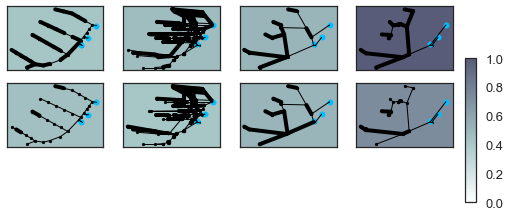

In [25]:
#Grid plot of SKS sub-ensemble performance

#Set up data:
#get all 2nd-round data that will be plotted, with correct ordering and indices, and put it all in one dataframe
fit = pd.DataFrame(index=['base'], columns=['sksRunID','ind', 'fit','stdev', 'diameters','%restrict']) #create empty dataframe
gpRunID = gpIDs[0]
for j in range(nruns['sks'][0]):                #loop over all SKS runs for first round
    sksRunID = sksIDs[j]                        #get SKS ID for current run
    if sksRunID in subEnsemble:                 #for SKS runs chosen for sub-ensemble
        for k in range(nruns['swmm'][0]):           #loop over SWMM runs (round 2)
            swmmRunID = sksRunID + 'swmm' + str(k)  #create ID string
            if swmmRunID in subset:            #if in the smaller behavioral subset of 10
                fit.loc[swmmRunID,'sksRunID']  = sksRunID        #store SKS ID
                fit.loc[swmmRunID,'ind']       = j               #store SKS index
                diameters                      = data.loc[(gpRunID, sksRunID, swmmRunID),'diameters']
                fit.loc[swmmRunID,'diameters'] = diameters
                fit.loc[swmmRunID,'%restrict'] = diameters.count(1) / len(diameters)    #calculate % of conduits that are restricted
                fit.loc[swmmRunID,'fit']       = np.sum([stats.loc[(spring, 'RMSE'), swmmRunID]/np.mean(Qobs[spring]) for spring in springs]) #calculate sum of RMSE at each spring normalized by mean observed discharge at that spring

#Reference:
fit.loc['base','fit']  = np.sum([stats.loc[(spring, 'RMSE'), 'base']/np.mean(Qobs[spring]) for spring in springs])  #calculate overall fit metric for base network
for k in range(nruns['swmm'][0]):               #loop over SWMM runs (round 2)
    swmmRunID = 'base' + 'swmm' + str(k)        #create ID string
    if swmmRunID in subsetRef:            #if in the smaller behavioral subset of 10
        fit.loc[swmmRunID,'fit']       = np.sum([stats.loc[(spring, 'RMSE'), swmmRunID]/np.mean(Qobs[spring]) for spring in springs]) #calculate sum of RMSE at each spring normalized by mean observed discharge at that spring
        diameters                      = data.loc[('base', 'base', swmmRunID),'diameters']
        fit.loc[swmmRunID,'diameters'] = diameters
        fit.loc[swmmRunID,'%restrict'] = diameters.count(1) / len(diameters)    #calculate % of conduits that are restricted

#Normalize fit metric & calculate stdev across all SWMM runs for each SKS run:
fit['norm']  = (fit.fit - np.min(fit.fit)) / (np.max(fit.fit) - np.min(fit.fit)) #normalize data to be between 0 and 1 for color mapping
for j in range(len(subEnsemble)):
    sksRunID = subEnsemble[j]
    swmmRunIDs = [sksRunID + 'swmm'+ str(k) for k in range(len(subEnsemble))] #get list of names of SWMM runs for current SKS run
    swmmRunIDs = [swmmRunID for swmmRunID in swmmRunIDs if swmmRunID in subset] #select only those in the smaller behavioral subset of 10
    fit.loc[swmmRunIDs, 'stdev'] = np.std(fit.loc[swmmRunIDs,'fit']) #calculate & store std. deviation of normalized fit
fit.sort_values(by=['stdev'], inplace=True)                   #sort by std.dev. 

###########################################
#Set up plot:
f = plt.figure(figsize=(2*(len(subEnsemble)+1),2*nkeep))                 #create empty figure of (width, height)
gs   = matplotlib.gridspec.GridSpec(len(subEnsemble),len(subEnsemble)+1)      #set up grid with (nrows, ncols)
cmap = matplotlib.cm.get_cmap('bone_r')         #get colormap object to select colors from ('bone_r')
cmap = truncate_colormap(cmap, 0.0, 0.6)        #truncate colormap to avoid very dark section
m    = matplotlib.cm.ScalarMappable(cmap=cmap)  #create mappable object for colorbar

#Plot reference network in first col:
subsetRef_sortRestrict = fit.loc[subsetRef,:].sort_values(by='%restrict').index.values #get run IDs sorted by increasing % of conduits restricted
#for k,swmmRunID in enumerate(subsetRef):        #loop over SWMM subset of 10 behavioral runs
for k,swmmRunID in enumerate(subsetRef_sortRestrict):   #loop over SWMM subset of 10 behavioral runs, sorted by increasing % restriction
    ax = f.add_subplot(gs[k,0])                 #add subplot in row,col
    diameters = fit.loc[swmmRunID,'diameters']  
    linewidth = [d*0.5 for d in diameters]
    sp.plot_map(base_nodes, base_links, dim=2, fig=f, ax=ax, lw=linewidth)
    color = cmap(float(fit.norm[swmmRunID]))   #get color from colormap
    ax.set_facecolor(color)
    ax.set_yticks([])                          #hide axis ticks 
    ax.set_xticks([])                          #hide axis ticks 
    #ax.set_xlabel('ref')

##################################
#Plot sub-ensemble:
#for j, sksRunID in enumerate(pd.unique(fit.sksRunID[~pd.isnull(fit.sksRunID)])): #loop over sub ensemble SKS runs in order of increasing variance
for j, sksRunID in enumerate(subEnsemble_sortStd):  #loop over subensemble SKS runs sorted by stdv in initial ensemble (preserves order from previous figures)
    nodes = nodesAll.loc['simple',sksRunID]     #retrieve current network geometry
    links = linksAll.loc['simple',sksRunID]
    swmmRunIDs_sortRestrict = fit[fit.sksRunID==sksRunID].sort_values(by='%restrict').index.values  #get run IDs sorted by increasing % of conduits restricted
    #for k, swmmRunID in enumerate(fit.index[fit.sksRunID==sksRunID]):           #loop over SWMM runs for sub-ensemble (round 2)
    for k, swmmRunID in enumerate(swmmRunIDs_sortRestrict): #loop over SWMM runs for sub-ensemble (round 2)
        ax        = f.add_subplot(gs[k,j+1])          #add subplot in grid [row=SWMM,col=SKS]
        diameters = fit.loc[swmmRunID,'diameters']
        linewidth = [d*0.5 for d in diameters]
        sp.plot_map(nodes,links, dim=2, fig=f, ax=ax, lw=linewidth)  #plot each individual simple conduit map
        color = cmap(float(fit.norm[swmmRunID]))    #get color from colormap
        ax.set_facecolor(color)                     #set background color of current subplot
        ax.set_yticks([])                           #hide axis ticks 
        ax.set_xticks([])  
        #ax.set_xlabel(fit.ind[fit.sksRunID==sksRunID][0]) #label subplots with index of each network
cax = f.add_axes([0.92, 0.2, 0.02, 0.5]) #[left, bottom, width, height] in fraction of current fig dimensions (for colorbar axes)
f.colorbar(m, cax=cax)                          #plot colorbar using mappable object on new axes
plt.suptitle('Conduit network performance in sub-ensemble ('+str(metric)+') (sorted by variance & % restriction)', x=0.5,y=0.9)
print('done')

In [ ]:
#Scatterplot of % of conduits restricted vs. global error
f = plt.figure(figsize=(8,8))

#Round 1:
run=True
if run == True:
    restrict     = []
    error        = []
    for j in range(nruns['sks'][0]):            
        sksRunID = sksIDs[j]                    
        for k in range(len(restrictBehavior)):                                 
            swmmRunID = sksRunID + 'swmmR1_' + restrictBehavior[k]             #get swmm ID for 1st round
            diameters = data.loc[(gpIDs[0], sksRunID, swmmRunID),'diameters']  #get diameter list
            restrict.append(diameters.count(1) / len(diameters))               #calculate % of conduits that are restricted
            error.append(np.sum([stats.loc[(spring, 'RMSE'), swmmRunID]/np.mean(Qobs[spring]) for spring in springs])) #calculate global error 
    plt.scatter(restrict, error, c='silver')

#Round 2:
restrict     = []
error        = []
for j, sksRunID in enumerate(subEnsemble):
    for k in range(nruns['swmm'][0]):
        swmmRunID = sksRunID + 'swmm' + str(k)   #get list of swmm IDs for current SKS run
        if swmmRunID in subset:              #select only those in the smaller behavioral subset of 10
            diameters = data.loc[(gpIDs[0], sksRunID, swmmRunID),'diameters']  #get diameter list
            restrict.append(diameters.count(1) / len(diameters))               #calculate % of conduits that are restricted
            error.append(np.sum([stats.loc[(spring, 'RMSE'), swmmRunID]/np.mean(Qobs[spring]) for spring in springs])) #calculate global error 
plt.scatter(restrict, error, c='deepskyblue')

#Reference network:
restrict     = []
error        = []
sksRunID = 'base'
for k in range(nruns['swmm'][0]):
    swmmRunID = sksRunID + 'swmm' + str(k)   #get list of swmm IDs for current SKS run
    if swmmRunID in subsetRef:              #select only those in the smaller behavioral subset of 10
        diameters = data.loc[('base', sksRunID, swmmRunID),'diameters']  #get diameter list
        restrict.append(diameters.count(1) / len(diameters))               #calculate % of conduits that are restricted
        error.append(np.sum([stats.loc[(spring, 'RMSE'), swmmRunID]/np.mean(Qobs[spring]) for spring in springs])) #calculate global error 
plt.scatter(restrict, error, c='goldenrod')

#Reference model:
diameters = baseDiameters  #get diameter list
restrict  = list(diameters<np.mean(diameters)).count(True) / len(diameters)           #calculate % of conduits that are restricted
error     = np.sum([stats.loc[(spring, 'RMSE'), swmmRunID]/np.mean(Qobs[spring]) for spring in springs]) #calculate global error 
plt.scatter(restrict, error, c='sienna')

plt.title('Effect of conduit restrictions on model performance')
plt.xlabel('% of conduits restricted')
plt.ylabel('Global error')
#plt.yscale('log')
plt.legend(['initial ensemble (n=' + str(nruns['sks'][0]*len(restrictBehavior)) + ')', 
            'sub-ensemble (n='+str(len(subEnsemble)*nkeep)+')', 
            'reference network (n='+str(nkeep)+')', 
            'reference model'])
#plt.legend(['sub-ensemble (n=100)', 'reference network (n=10)', 'reference model'])

### END OF WORKING SECTION
Miscellaneous additional plots that may or may not be in working order

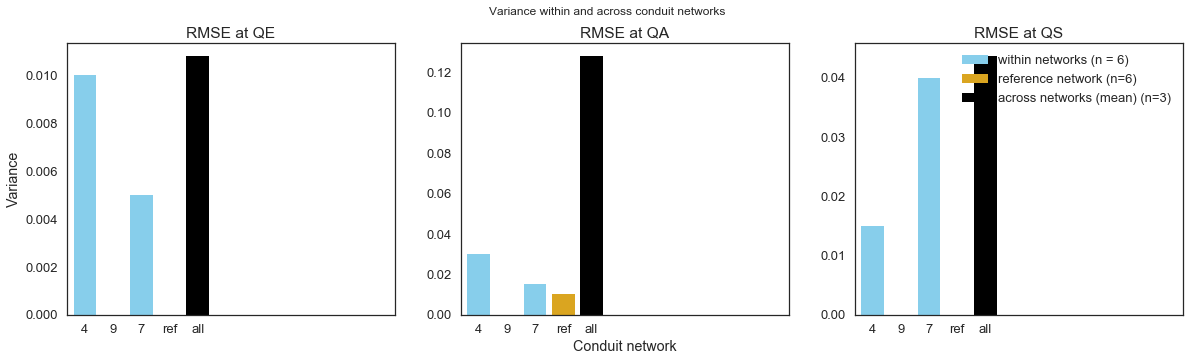

In [58]:
#OLD - DO NOT USE: Bar plot of within-network vs. across-network variance:

f,ax = plt.subplots(1,3,figsize=(20,5))
for s,spring in enumerate(springs):
    metric = (spring,'RMSE')
    for i in range(nruns['gempy'][0]):                  #loop over GemPy runs
        gpRunID     = gpIDs[i]                          #get Gempy ID for current run 
        swmmMeans   = []
        swmmMedians = []
        swmmStds    = []
        for j in range(len(subEnsemble)):               #loop over SKS sub-ensemble
            sksRunID = subEnsemble_sortStd[j]           #get SKS ID for current run (sorted by stdev)
            errors = [] 
            for k in range(nruns['swmm'][0]):           #loop over SWMM runs
                swmmRunID = sksRunID + 'swmm' + str(k)  #create run ID string (round 2)
                if swmmRunID in subset:                 #if in behavioral subset of 10
                    errors.append(stats.loc[metric,swmmRunID])
            swmmMean   = np.mean(errors)                #get mean of all SWMM runs for current SKS run
            swmmMedian = np.median(errors)              #get median of all SWMM runs for current SKS run
            swmmStd    = np.std(errors)                 #get within-network variance across all SWMM runs for current SKS run
            swmmMeans.append(swmmMean)                  #store 
            swmmMedians.append(swmmMedian)
            swmmStds.append(swmmStd)
        sksMean   = np.mean(swmmMeans)                 #get mean of means, for all SWMM runs on all networks
        sksMedian = np.median(swmmMedians)             #get median of medians, for SWMM runs on all networks
        sksStd    = np.std(swmmMeans)                 #variance of means across networks
    
    #For reference network:
    sksRunID = 'base'
    errors = []
    for k in range(nruns['swmm'][0]):           #loop over SWMM runs for reference model
        swmmRunID = sksRunID + 'swmm' + str(k)  #create run ID string (round 2)
        if swmmRunID in subsetRef:              #if in behavioral subset of 10
            errors.append(stats.loc[metric,swmmRunID])
    refMean   = np.mean(errors)                #get mean of all SWMM runs for reference network
    refMedian = np.median(errors)              #get median of all SWMM runs for reference network
    refStd    = np.std(errors)                 #get within-network variance across all SWMM runs for reference network
    
    #Plot:
    #ax[s].bar(np.arange(len(subEnsemble)), swmmStds, color='skyblue',     tick_label=[iSubEnsemble.ind[iSubEnsemble.index==sksID].values[0] for sksID in subEnsemble])
    ax[s].bar(np.arange(len(subEnsemble)), swmmStds, color='skyblue',     tick_label=iSubEnsemble_sortStd)
    ax[s].bar(len(subEnsemble),            refStd,   color = 'goldenrod', tick_label='ref' )
    ax[s].bar(len(subEnsemble)+1,          sksStd,   color='k',           tick_label='all')
    ax[s].set_title(metric[1]+' at '+metric[0])
    ax[s].set_xticks(np.arange(12))
    #ax[s].set_xticklabels(np.append([iSubEnsemble.ind[iSubEnsemble.index==sksID].values[0] for sksID in subEnsemble],['ref','all']))
    ax[s].set_xticklabels(np.append(iSubEnsemble_sortStd,['ref','all']))

f.suptitle('Variance within and across conduit networks')
ax[0].set_ylabel('Variance')
ax[1].set_xlabel('Conduit network')
plt.legend(['within networks (n = '+str(len(subset))+')', 
            'reference network (n='+str(len(subset))+')', 
            'across networks (mean) (n='+str(len(subEnsemble))+')'])

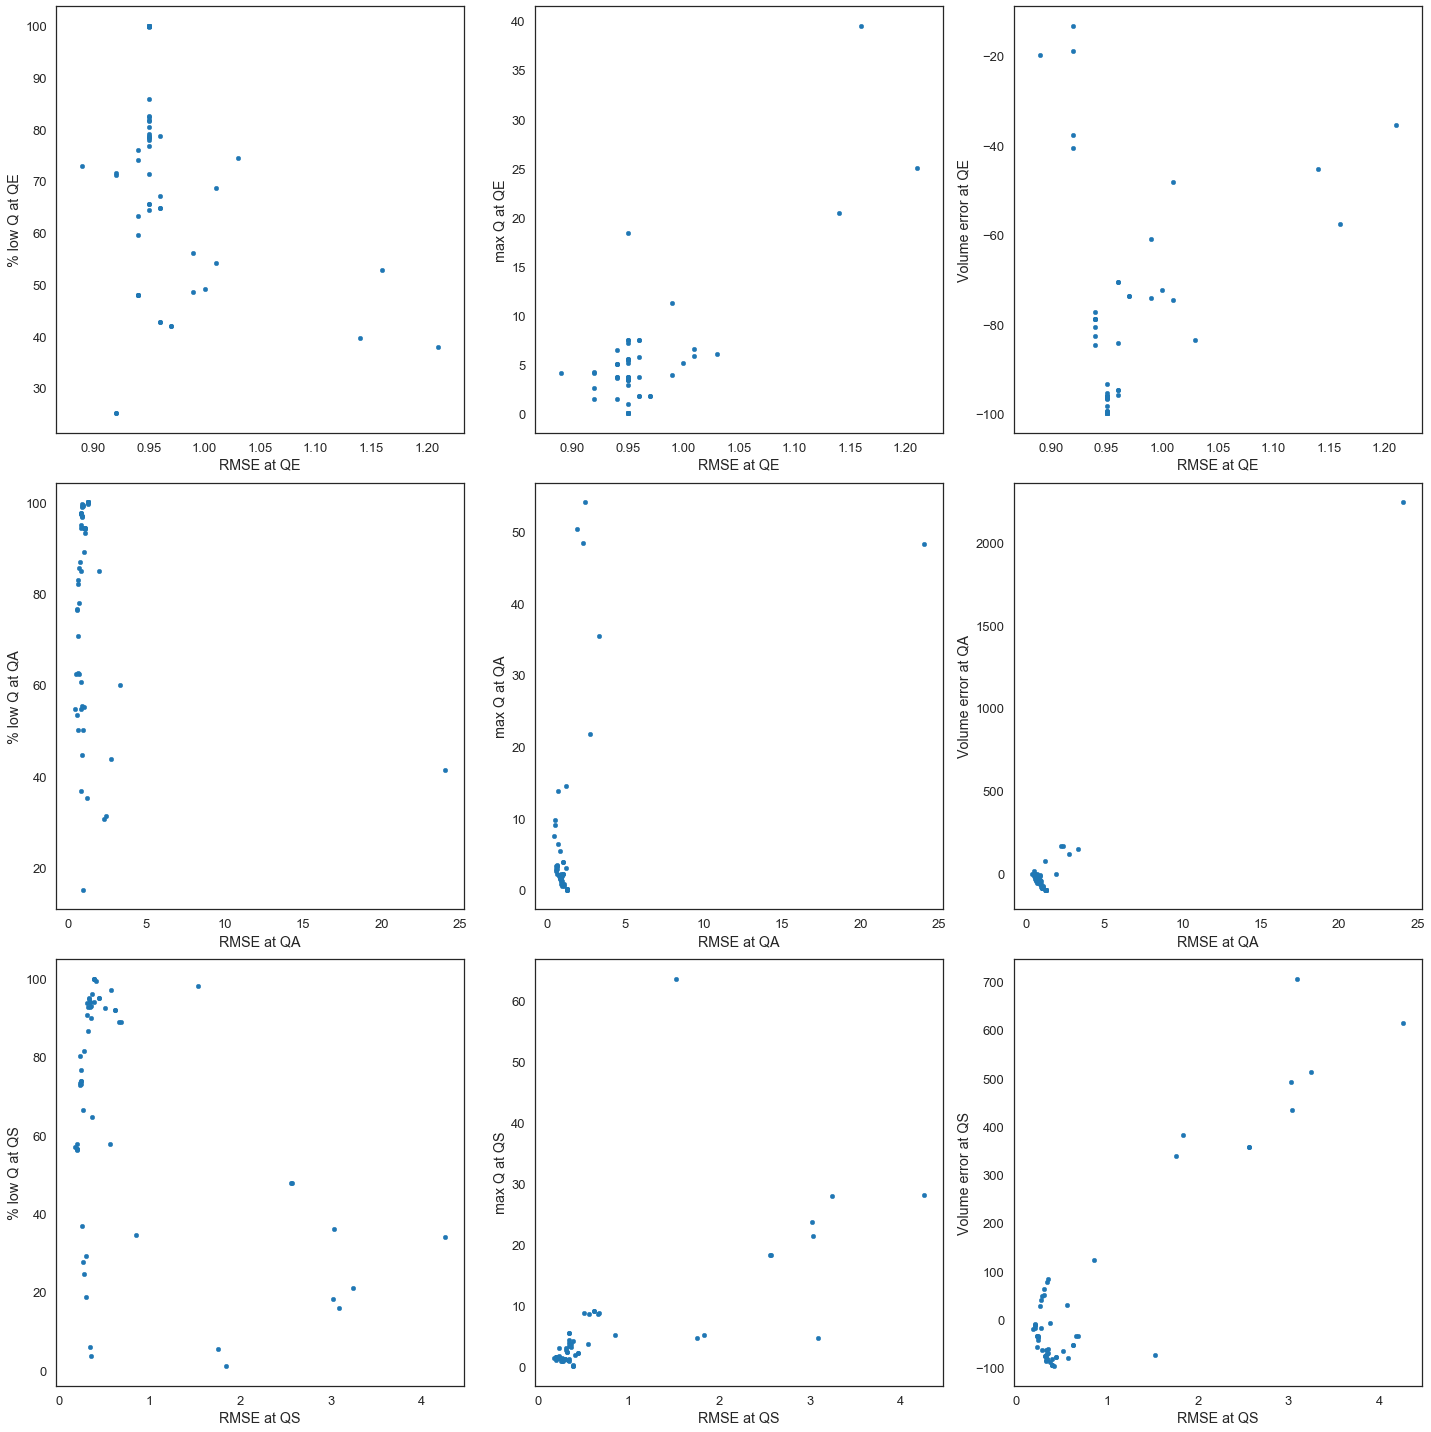

In [69]:
#Scatterplots of error metrics:
f, ax = plt.subplots(3,3,figsize=(20,20))

#QE
lowQ  = np.asarray(stats.loc[('QE','%lowQ'), swmmIDs].values, dtype='float') #convert to float arrays for plotting etc.
RMSE  = np.asarray(stats.loc[('QE','RMSE'),  swmmIDs].values, dtype='float')
meanQ = np.asarray(stats.loc[('QE','meanQ'), swmmIDs].values, dtype='float')
VE    = np.asarray(stats.loc[('QE','VE'),    swmmIDs].values, dtype='float')
maxQ  = np.asarray(stats.loc[('QE','maxQ'),  swmmIDs].values, dtype='float')
ax[0,0].scatter(RMSE, lowQ, marker='.')
ax[0,0].set_xlabel('RMSE at QE')
ax[0,0].set_ylabel('% low Q at QE')
ax[0,1].scatter(RMSE, maxQ, marker='.')
ax[0,1].set_xlabel('RMSE at QE')
ax[0,1].set_ylabel('max Q at QE')
ax[0,2].scatter(RMSE, VE, marker='.')
ax[0,2].set_xlabel('RMSE at QE')
ax[0,2].set_ylabel('Volume error at QE')

#QA
lowQ  = np.asarray(stats.loc[('QA','%lowQ'), swmmIDs].values, dtype='float') #convert to float arrays for plotting etc.
RMSE  = np.asarray(stats.loc[('QA','RMSE'),  swmmIDs].values, dtype='float')
meanQ = np.asarray(stats.loc[('QA','meanQ'), swmmIDs].values, dtype='float')
VE    = np.asarray(stats.loc[('QA','VE'),    swmmIDs].values, dtype='float')
maxQ  = np.asarray(stats.loc[('QA','maxQ'),  swmmIDs].values, dtype='float')
ax[1,0].scatter(RMSE, lowQ, marker='.')
ax[1,0].set_xlabel('RMSE at QA')
ax[1,0].set_ylabel('% low Q at QA')
ax[1,1].scatter(RMSE, maxQ, marker='.')
ax[1,1].set_xlabel('RMSE at QA')
ax[1,1].set_ylabel('max Q at QA')
ax[1,2].scatter(RMSE, VE, marker='.')
ax[1,2].set_xlabel('RMSE at QA')
ax[1,2].set_ylabel('Volume error at QA')

#QS
lowQ  = np.asarray(stats.loc[('QS','%lowQ'), swmmIDs].values, dtype='float') #convert to float arrays for plotting etc.
RMSE  = np.asarray(stats.loc[('QS','RMSE'),  swmmIDs].values, dtype='float')
meanQ = np.asarray(stats.loc[('QS','meanQ'), swmmIDs].values, dtype='float')
VE    = np.asarray(stats.loc[('QS','VE'),    swmmIDs].values, dtype='float')
maxQ  = np.asarray(stats.loc[('QS','maxQ'),  swmmIDs].values, dtype='float')
ax[2,0].scatter(RMSE, lowQ, marker='.')
ax[2,0].set_xlabel('RMSE at QS')
ax[2,0].set_ylabel('% low Q at QS')
ax[2,1].scatter(RMSE, maxQ, marker='.')
ax[2,1].set_xlabel('RMSE at QS')
ax[2,1].set_ylabel('max Q at QS')
ax[2,2].scatter(RMSE, VE, marker='.')
ax[2,2].set_xlabel('RMSE at QS')
ax[2,2].set_ylabel('Volume error at QS')
plt.tight_layout()


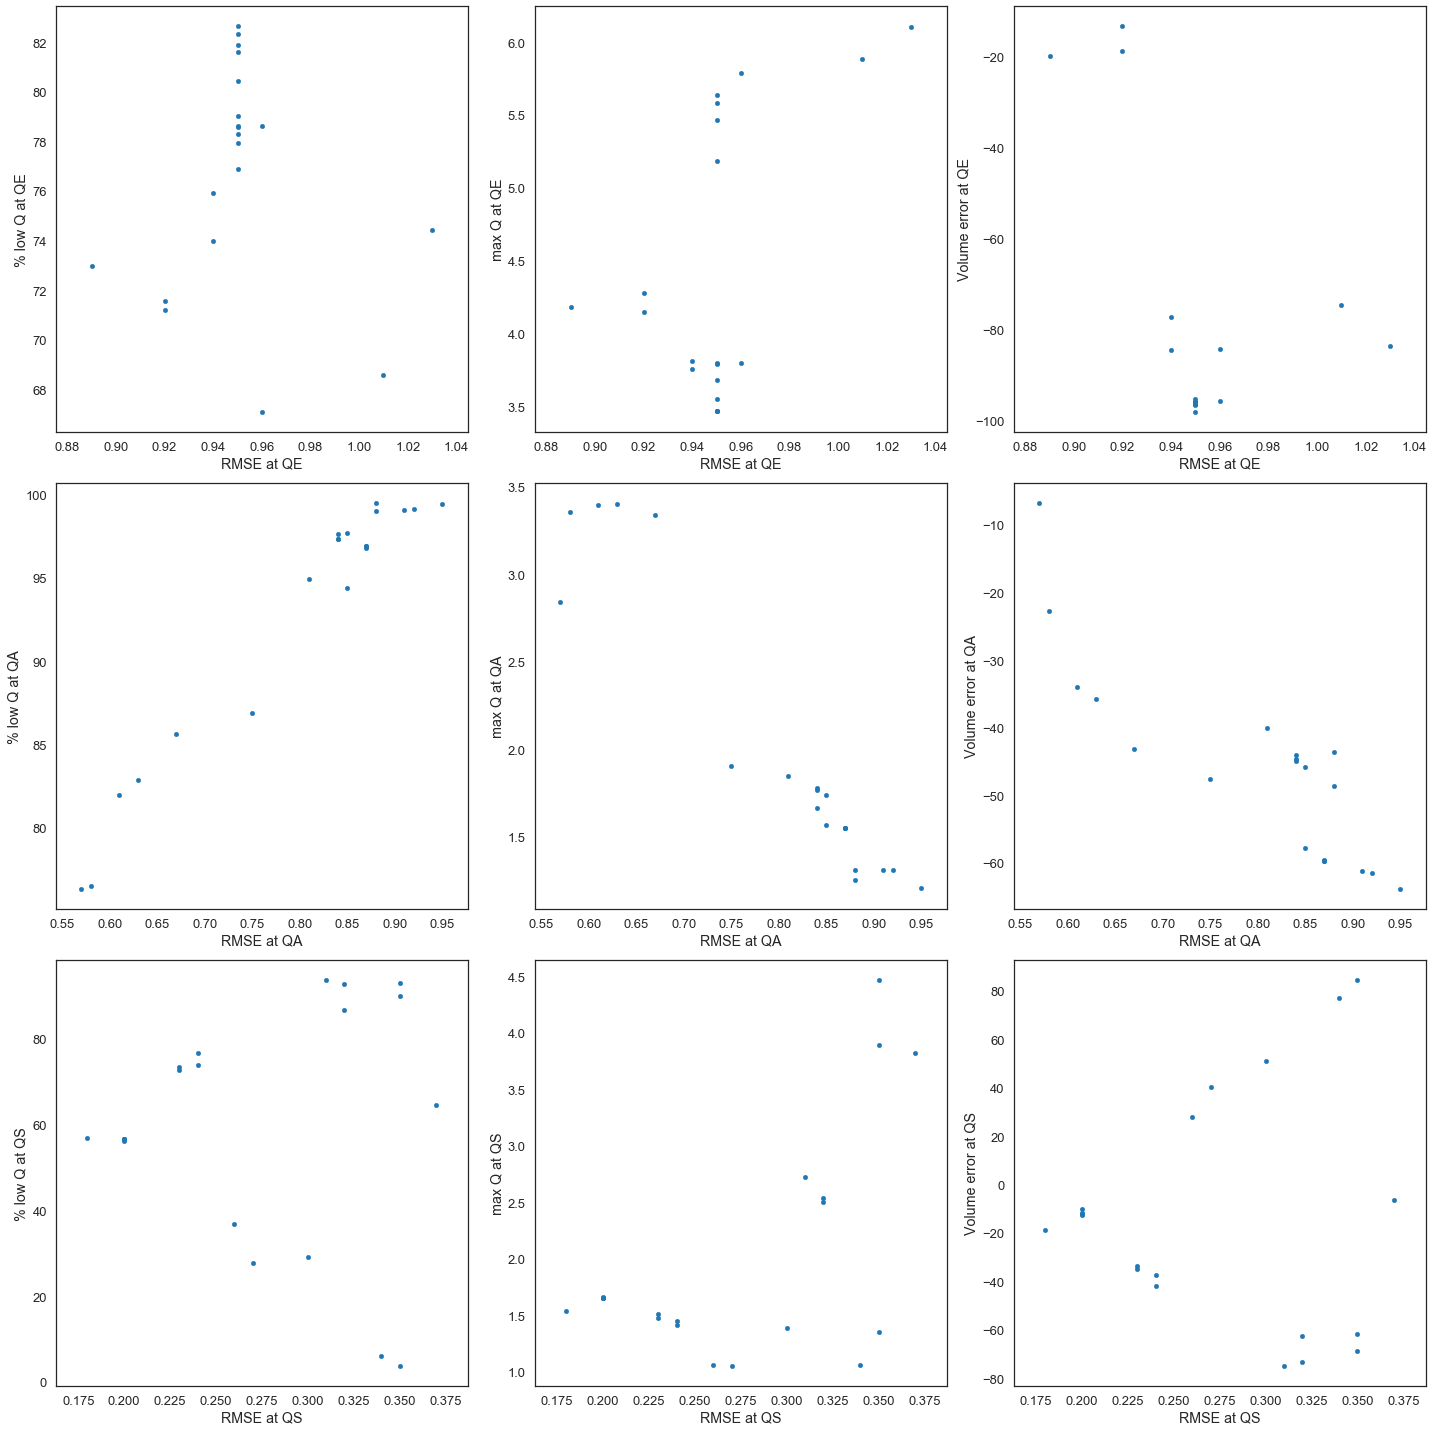

In [70]:
#Scatterplots of error metrics:
#Get just round 2 IDs:
swmmIDsR2 = []
for swmmID in swmmIDs:
    if 'R1' not in swmmID:
        swmmIDsR2.append(swmmID)
swmmIDsR2

#Plot:
f, ax = plt.subplots(3,3,figsize=(20,20))

#QE
lowQ  = np.asarray(stats.loc[('QE','%lowQ'), swmmIDsR2].values, dtype='float') #convert to float arrays for plotting etc.
RMSE  = np.asarray(stats.loc[('QE','RMSE'),  swmmIDsR2].values, dtype='float')
meanQ = np.asarray(stats.loc[('QE','meanQ'), swmmIDsR2].values, dtype='float')
VE    = np.asarray(stats.loc[('QE','VE'),    swmmIDsR2].values, dtype='float')
maxQ  = np.asarray(stats.loc[('QE','maxQ'),  swmmIDsR2].values, dtype='float')
ax[0,0].scatter(RMSE, lowQ, marker='.')
ax[0,0].set_xlabel('RMSE at QE')
ax[0,0].set_ylabel('% low Q at QE')
ax[0,1].scatter(RMSE, maxQ, marker='.')
ax[0,1].set_xlabel('RMSE at QE')
ax[0,1].set_ylabel('max Q at QE')
ax[0,2].scatter(RMSE, VE, marker='.')
ax[0,2].set_xlabel('RMSE at QE')
ax[0,2].set_ylabel('Volume error at QE')

#QA
lowQ  = np.asarray(stats.loc[('QA','%lowQ'), swmmIDsR2].values, dtype='float') #convert to float arrays for plotting etc.
RMSE  = np.asarray(stats.loc[('QA','RMSE'),  swmmIDsR2].values, dtype='float')
meanQ = np.asarray(stats.loc[('QA','meanQ'), swmmIDsR2].values, dtype='float')
VE    = np.asarray(stats.loc[('QA','VE'),    swmmIDsR2].values, dtype='float')
maxQ  = np.asarray(stats.loc[('QA','maxQ'),  swmmIDsR2].values, dtype='float')
ax[1,0].scatter(RMSE, lowQ, marker='.')
ax[1,0].set_xlabel('RMSE at QA')
ax[1,0].set_ylabel('% low Q at QA')
ax[1,1].scatter(RMSE, maxQ, marker='.')
ax[1,1].set_xlabel('RMSE at QA')
ax[1,1].set_ylabel('max Q at QA')
ax[1,2].scatter(RMSE, VE, marker='.')
ax[1,2].set_xlabel('RMSE at QA')
ax[1,2].set_ylabel('Volume error at QA')

#QS
lowQ  = np.asarray(stats.loc[('QS','%lowQ'), swmmIDsR2].values, dtype='float') #convert to float arrays for plotting etc.
RMSE  = np.asarray(stats.loc[('QS','RMSE'),  swmmIDsR2].values, dtype='float')
meanQ = np.asarray(stats.loc[('QS','meanQ'), swmmIDsR2].values, dtype='float')
VE    = np.asarray(stats.loc[('QS','VE'),    swmmIDsR2].values, dtype='float')
maxQ  = np.asarray(stats.loc[('QS','maxQ'),  swmmIDsR2].values, dtype='float')
ax[2,0].scatter(RMSE, lowQ, marker='.')
ax[2,0].set_xlabel('RMSE at QS')
ax[2,0].set_ylabel('% low Q at QS')
ax[2,1].scatter(RMSE, maxQ, marker='.')
ax[2,1].set_xlabel('RMSE at QS')
ax[2,1].set_ylabel('max Q at QS')
ax[2,2].scatter(RMSE, VE, marker='.')
ax[2,2].set_xlabel('RMSE at QS')
ax[2,2].set_ylabel('Volume error at QS')
plt.tight_layout()


In [130]:
#Select best-performing SWMM run for each SKS network:
#Choose run with lowest RMSE at QS, then QE, then QA, then random.
#Spring ordering is based on apparent sensitivity.
metric1 = ('QS','RMSE')  #define metrics to be used in order of preference
metric2 = ('QE','RMSE')
metric3 = ('QA','RMSE')

#For entire ensemble:
best = []                #set up empty list to store indices of best SWMM runs
for i in range(nruns['gempy'][0]):                  #loop over GemPy runs
    gpRunID = gpIDs[i]                              #get Gempy ID for current run   
    for j,sksRunID in enumerate(sksIDs):            #loop over entire SKS ensemble
        names = []                                  #reset empty list for each SKS run
        for k in range(nruns['swmmRound1'][0]):    #loop over SWMM runs (round 1)
            swmmRunID = sksRunID + 'swmmR1_' + restrictBehavior[k]      #create run ID string (round 1)
            names.append(swmmRunID)                 #store run name
        errors = stats.loc[metric1,names]           #get error stats for desired metric and all runs selected 
        best1 = errors[errors==np.min(errors)].index #get the names of the runs with the lowest values for the desired metric
        if len(best1)>1:                            #if there are multiple runs with equally low values
            errors = stats.loc[metric2,best1]       #repeat but using the second metric
            best2 = best1[errors==np.min(errors)]
            if len(best2)>1:                        #if there are still multiple runs with equally low values
                errors = stats.loc[metric3, best2]  #repeat using the third metric
                best3 = best2[errors==np.min(errors)]
                if len(best3)>1:                   #if there are still multiple runs with equally low values
                    best4 = best3[random.randint(0,len(best3)-1)]  #choose one at random
                    best.append(best4)             #store the result
                else:
                    best.append(best3[0])
            else:
                best.append(best2[0])
        else:
            best.append(best1[0])
print('Best SWMM run for each SKS network in entire ensemble:\n', best)

#For sub-ensemble:
bestSub = []                #set up empty list to store indices of best SWMM runs
for i in range(nruns['gempy'][0]):                  #loop over GemPy runs
    gpRunID = gpIDs[i]                              #get Gempy ID for current run   
    for j,ind in enumerate(iSubEnsemble.ind):           #loop over SKS sub-ensemble
        sksRunID = sksIDs[ind]                      #get SKS ID for current run
        names = []                                  #reset empty list for each SKS run
        for k in range(nruns['swmm'][0]):           #loop over SWMM runs for sub-ensemble (round 2)
            swmmRunID = sksRunID + 'swmm' + str(k)  #create run ID string (round 2)
            names.append(swmmRunID)                 #store run name
        errors = stats.loc[metric1,names]           #get error stats for desired metric and all runs selected 
        best1 = errors[errors==np.min(errors)].index #get the names of the runs with the lowest values for the desired metric
        if len(best1)>1:                            #if there are multiple runs with equally low values
            errors = stats.loc[metric2,best1]       #repeat but using the second metric
            best2 = best1[errors==np.min(errors)]
            if len(best2)>1:                        #if there are still multiple runs with equally low values
                errors = stats.loc[metric3, best2]  #repeat using the third metric
                best3 = best2[errors==np.min(errors)]
                if len(best3)>1:                   #if there are still multiple runs with equally low values
                    best4 = best3[random.randint(0,len(best3)-1)]  #choose one at random
                    bestSub.append(best4)             #store the result
                else:
                    bestSub.append(best3)
            else:
                bestSub.append(best2[0])
        else:
            bestSub.append(best1[0])
print('Best SWMM run for each SKS network in sub-ensemble:\n', bestSub)

#For reference network:
names = []                      #reset empty list for each SKS run
gpRunID  = 'base'               #manually set GemPy ID
sksRunID = 'base'               #manually set set SKS ID 
for k in range(nruns['swmm'][0]):     #loop over SWMM runs for sub-ensemble (round 2)
    swmmRunID = sksRunID + 'swmm' + str(k)  #create run ID string (round 2)
    names.append(swmmRunID)                 #store run name
errors = stats.loc[metric1,names]           #get error stats for desired metric and all runs selected 
best1 = errors[errors==np.min(errors)].index #get the names of the runs with the lowest values for the desired metric
if len(best1)>1:                            #if there are multiple runs with equally low values
    errors = stats.loc[metric2,best1]       #repeat but using the second metric
    best2 = best1[errors==np.min(errors)]
    if len(best2)>1:                        #if there are still multiple runs with equally low values
        errors = stats.loc[metric3, best2]  #repeat using the third metric
        best3 = best2[errors==np.min(errors)]
        if len(best3)>1:                   #if there are still multiple runs with equally low values
            best4 = best3[random.randint(0,len(best3)-1)]  #choose one at random
            bestReference = best4             #store the result
        else:
            bestReference = best3
    else:
        bestReference = best2[0]
else:
    bestReference = best1[0]
print('\nBest SWMM run for Reference network:\n', bestReference)

Best SWMM run for each SKS network in entire ensemble:
 ['GKgp01020sks132010011503000000002swmmR1_low', 'GKgp01020sks122010011611111110002swmmR1_low', 'GKgp01020sks112210011835111110002swmmR1_QS', 'GKgp01020sks122210011289222220002swmmR1_QS', 'GKgp01020sks152010011396222220002swmmR1_low', 'GKgp01020sks132210011275111110002swmmR1_low', 'GKgp01020sks172110011128111110002swmmR1_low', 'GKgp01020sks102110011074222220002swmmR1_low', 'GKgp01020sks162210011309111110002swmmR1_low', 'GKgp01020sks102110011714222220002swmmR1_QS', 'GKgp01020sks172110011286222220002swmmR1_low', 'GKgp01020sks102110011730111110002swmmR1_QS', 'GKgp01020sks102010011889222220002swmmR1_QS', 'GKgp01020sks152110011662000000002swmmR1_low', 'GKgp01020sks152010011037000000002swmmR1_QS', 'GKgp01020sks122210011955222220002swmmR1_QS', 'GKgp01020sks172110011359000000002swmmR1_low', 'GKgp01020sks172210011238111110002swmmR1_QS', 'GKgp01020sks142210011290000000002swmmR1_low', 'GKgp01020sks152110011843000000002swmmR1_low', 'GKgp01020s

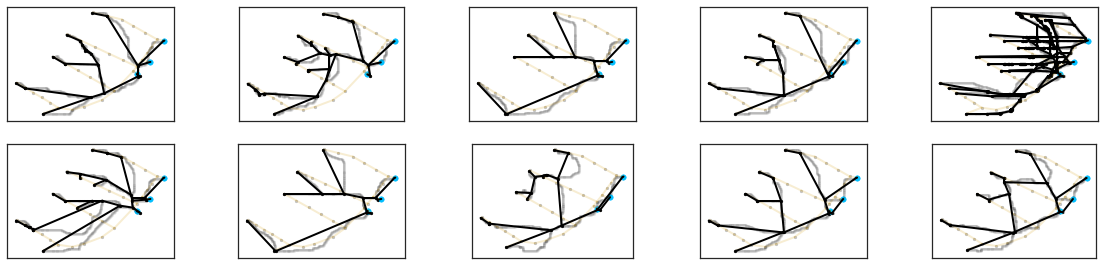

In [73]:
#Plot flattened map views of networks in entire ensemble compared to reference network and unsimplified network:
f = plt.figure(figsize=(20,5*10))                 #create an empty figure for the individual plots                         
for i in range(nruns['sks'][0]):               #loop over sks ID indices in subEnsemble
    sksRunID = sksIDs[i]                   #get current ID
    ax      = f.add_subplot(20,5, i+1)           #add subplots in grid
    sp.plot_map(base_nodes, base_links, dim=2, fig=f, ax=ax, c='goldenrod', a=0.2)
    #Complex:
    nodes = nodesAll.loc['complex',sksRunID]                #retrieve current network geometry
    links = linksAll.loc['complex',sksRunID]
    sp.plot_map(nodes,links, dim=2, fig=f,  ax=ax,  a=0.05) #plot each individual complex conduit map
    #Simplified:
    nodes = nodesAll.loc['simple',sksRunID]                 #retrieve current network geometry
    links = linksAll.loc['simple',sksRunID]
    sp.plot_map(nodes,links, dim=2, fig=f,  ax=ax)          #plot each individual simple conduit map
    #Format:
    ax.get_xaxis().set_visible(False)           #hide axis ticks & labels
    ax.get_yaxis().set_visible(False)
    #ax.set_title(sksID)                        #label each subplot with the name of corresponding SKS network


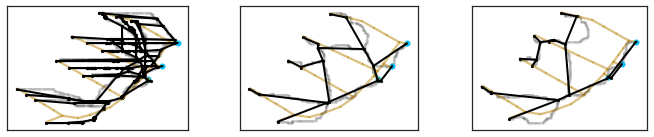

In [72]:
#Plot flattened map views of networks in sub-ensemble:
importlib.reload(sp)
f = plt.figure(figsize=(20,5))                  #create an empty figure for the individual plots    
cmap = matplotlib.cm.get_cmap('cividis')        #get colormap object to select colors from
for i in range(len(subEnsemble)):               #loop over sks ID indices in subEnsemble
    sksRunID = subEnsemble[i]                   #get current ID
    ax      = f.add_subplot(2,5, i+1)           #add subplots in grid
    #sp.plot_map(base_nodes, base_links, dim=2, fig=f, ax=ax, c='goldenrod')
    fromX = base_nodes.X.loc[base_links.InNode] #calculate coordinates for link start and end points
    fromY = base_nodes.Y.loc[base_links.InNode]
    toX   = base_nodes.X.loc[base_links.OutNode]
    toY   = base_nodes.Y.loc[base_links.OutNode]
    for ind in base_links.index:                             #loop over link indices
        ax.plot((fromX.iloc[ind],toX.iloc[ind]),(fromY.iloc[ind],toY.iloc[ind]), c='darkgoldenrod', alpha=0.5)     #plot links
    #ax.set_aspect('equal')
    #Complex:
    nodes = nodesAll.loc['complex',sksRunID]                #retrieve current network geometry
    links = linksAll.loc['complex',sksRunID]
    sp.plot_map(nodes,links, dim=2, fig=f,  ax=ax,  a=0.05) #plot each individual complex conduit map
    #Simplified:
    nodes = nodesAll.loc['simple',sksRunID]                 #retrieve current network geometry
    links = linksAll.loc['simple',sksRunID]
    sp.plot_map(nodes,links, dim=2, fig=f,  ax=ax)          #plot each individual simple conduit map
    #Format:
    ax.get_xaxis().set_visible(False)           #hide axis ticks & labels
    ax.get_yaxis().set_visible(False)
    #ax.set_title(sksID)                        #label each subplot with the name of corresponding SKS network


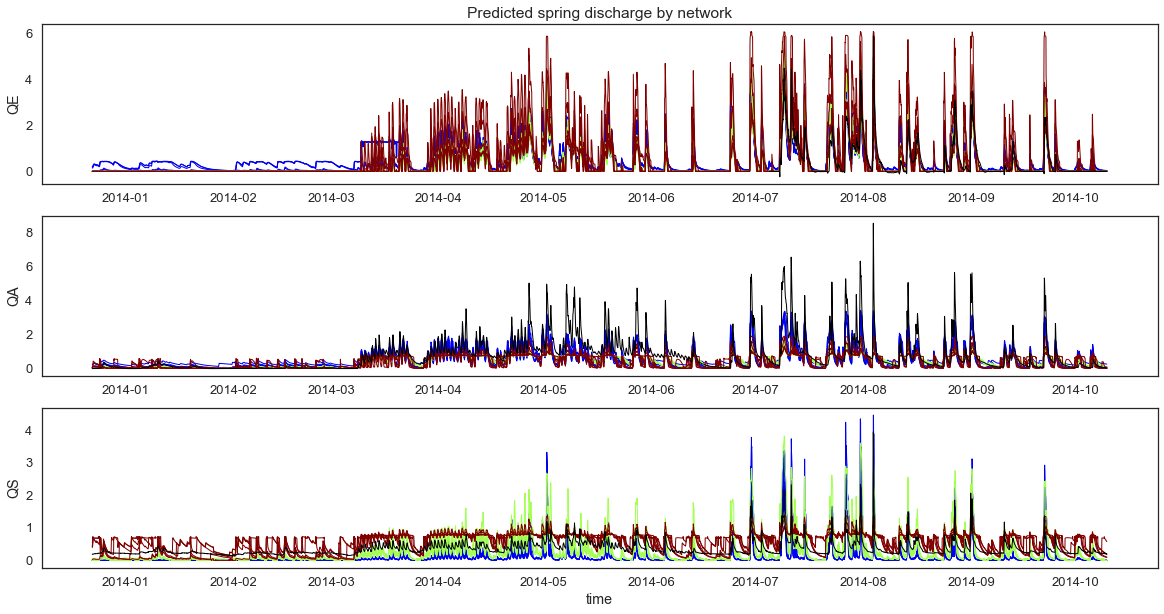

In [80]:
#Plot sub-ensemble timeseries by SKS run (each color is all SWMM runs for one SKS network):
#Set up figure & axes:
f = plt.figure(figsize=(20,10))                         #create figure to plot on
ax=[plt.subplot(311),plt.subplot(312),plt.subplot(313)] #create subplots for spring Q
ax[0].set_ylabel('QE')                                  #set plot y labels
ax[1].set_ylabel('QA')
ax[2].set_ylabel('QS')
ax[0].set_title('Predicted spring discharge by network')
ax[2].set_xlabel('time')
cmap = matplotlib.cm.get_cmap('jet')                #get colormap object to select colors from
colors = np.linspace(0.1,1,len(subEnsemble))         #set up list of evenly-spaced color indices to use
patches=[]
#Loop over runs & plot:
for i in range(nruns['gempy'][0]):                  #loop over GemPy runs
    gpRunID = gpIDs[i]                              #get Gempy ID for current run    
    for j in range(len(subEnsemble)):               #loop over SKS sub-ensemble
        sksRunID = subEnsemble[j]                   #get SKS ID for current run        
        patches.append(matplotlib.lines.Line2D([0],[0],color=cmap(colors[j]), label=sksRunID)) #create custom patches and legen
        for k in range(nruns['swmm'][0]):           #loop over SWMM runs for sub-ensemble (round 2)
            swmmRunID = sksRunID + 'swmm' + str(k)              #create run ID string (round 2)
            index      = (gpRunID,sksRunID,swmmRunID)           #set index for data storage
            plotQ(data.loc[index, 'Q'], c=cmap(colors[j]))      #plot each run
plotQ(data.loc[('obs','0','0'), 'Q'], c='k')                    #plot observed flow
#ax[2].legend(handles=patches)                                   #add custom legend to plot

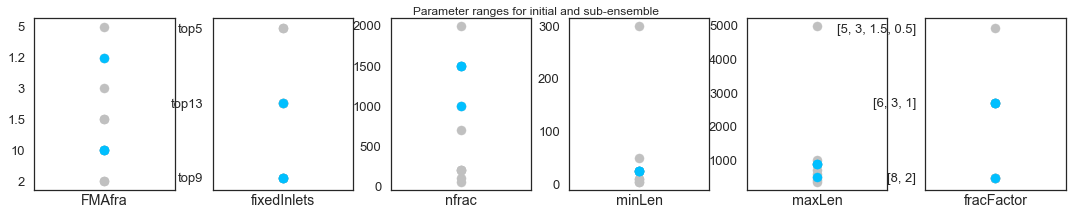

In [87]:
#Parameter ranges for entire SKS ensemble vs. sub-ensemble:

#Set up plots:
plotPars = ['FMAfra','fixedInlets','nfrac','minLen','maxLen','fracFactor'] #set which pars to plot
f,ax = plt.subplots(1,len(plotPars), figsize=(15,3))
#plt.scatter(np.full(len(sksIDs),0), allPars.loc['nfrac',sksIDs])
allPars.loc[plotPars,sksIDs]                                                #select those from the complete df
for i in range(len(plotPars)):
    ax[i].set_xticks([])
    ax[i].set_xlabel(plotPars[i])
plt.suptitle('Parameter ranges for initial and sub-ensemble')
plt.tight_layout()

#Plot par ranges for initial ensemble:
FMAfra = allPars.loc['FMAfra',sksIDs].values
ax[0].scatter(np.full(len(sksIDs),0), FMAfra, c='silver')
fixedInlets = allPars.loc['fixedInlets',sksIDs].values
ax[1].scatter(np.full(len(sksIDs),0), fixedInlets, c='silver')
nfrac      = [int(nfrac)    for nfrac  in allPars.loc['nfrac', sksIDs].values]
ax[2].scatter(np.full(len(sksIDs),0), nfrac,       c='silver')
minLen     = [float(minLen) for minLen in allPars.loc['minLen',sksIDs].values]
ax[3].scatter(np.full(len(sksIDs),0), minLen,      c='silver')
maxLen     = [float(maxLen) for maxLen in allPars.loc['maxLen',sksIDs].values]
ax[4].scatter(np.full(len(sksIDs),0), maxLen,     c='silver')
fracFactor = allPars.loc['fracFactor',sksIDs].values
ax[5].scatter(np.full(len(sksIDs),0), fracFactor, c='silver')

#Plot par ranges for sub-ensemble:
FMAfra = allPars.loc['FMAfra',subEnsemble].values
ax[0].scatter(np.full(len(subEnsemble),0), FMAfra, c='deepskyblue')
fixedInlets = allPars.loc['fixedInlets',subEnsemble].values
ax[1].scatter(np.full(len(subEnsemble),0), fixedInlets, c='deepskyblue')
nfrac = [int(nfrac) for nfrac in allPars.loc['nfrac',subEnsemble].values]
ax[2].scatter(np.full(len(subEnsemble),0), nfrac,       c='deepskyblue')
minLen = [float(minLen) for minLen in allPars.loc['minLen',subEnsemble].values]
ax[3].scatter(np.full(len(subEnsemble),0), minLen,      c='deepskyblue')
maxLen = [float(maxLen) for maxLen in allPars.loc['maxLen',subEnsemble].values]
ax[4].scatter(np.full(len(subEnsemble),0), maxLen,      c='deepskyblue')
fracFactor = allPars.loc['fracFactor',subEnsemble].values
ax[5].scatter(np.full(len(subEnsemble),0), fracFactor,  c='deepskyblue')